In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage, elo_save_feature
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys
from joblib import Parallel, delayed

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [37]:
clf = utils.read_pkl_gzip('../stack/0221_200_clf_lgb_out_part-clf_valid-ods_equal_foldseed328_ESET1_row201917_lr0.01_298feats_50seed_57leaves_colsample0.2513_iter694_OUT0_CV0-9088749366435246_LB.gz')[[key, 'prediction']].set_index(key)
clf.head()

,prediction
card_id,
C_ID_92a2005557,0.000212
C_ID_3d0044924f,0.007795
C_ID_d639edf6cd,0.003963
C_ID_186d6a6901,0.000500
C_ID_cdbd2c0db2,0.000175


In [38]:
base = utils.read_pkl_gzip('../input/base_no_out_clf.gz').set_index(key)
df_type = pd.read_csv('../input/card_ids_grouping.csv').set_index(key)
base = base.join(df_type)
base['clf_pred'] = clf
base.head()

,target,first_active_month,hist_purchase_date_max,hist_purchase_month_max,hist_purchase_date_min,hist_purchase_month_min,new_purchase_date_max,new_purchase_month_max,new_purchase_date_min,new_purchase_month_min,hist_personal_term,new_personal_term,hist_regist_term,new_regist_term,no_out_flg,clf_pred,type
card_id,,,,,,,,,,,,,,,,,
C_ID_92a2005557,-0.820283,2017-06-01,2018-02-25 09:31:15,2018-03-01,2017-06-27 14:18:08,2017-06-01,2018-04-29 11:23:05,2018-05-01,2018-03-05 14:04:36,2018-03-01,9,2.0,9,11.0,1.0,0.000212,2
C_ID_3d0044924f,0.392913,2017-01-01,2018-01-31 22:31:09,2018-02-01,2017-01-06 16:29:42,2017-01-01,2018-03-30 06:48:26,2018-04-01,2018-02-01 17:07:54,2018-02-01,13,2.0,13,15.0,0.0,0.007795,0
C_ID_d639edf6cd,0.688056,2016-08-01,2018-02-27 19:08:25,2018-03-01,2017-01-11 08:21:22,2017-01-01,2018-04-28 17:43:11,2018-05-01,2018-04-28 17:43:11,2018-04-01,14,1.0,19,18.0,0.0,0.003963,2
C_ID_186d6a6901,0.142495,2017-09-01,2018-02-28 11:44:40,2018-03-01,2017-09-26 16:22:21,2017-09-01,2018-04-18 11:00:11,2018-05-01,2018-03-07 11:55:06,2018-03-01,6,2.0,6,8.0,0.0,0.000500,2
C_ID_cdbd2c0db2,-0.159749,2017-11-01,2018-02-28 20:40:41,2018-03-01,2017-11-12 00:00:00,2017-11-01,2018-04-28 18:50:25,2018-05-01,2018-03-02 11:55:43,2018-03-01,4,2.0,4,6.0,1.0,0.000175,10


## No Outlier Flg
hist_regist_term<=4 or hist_purchase_month_max<='2017-04'

type: 0 | Count ID: 79425


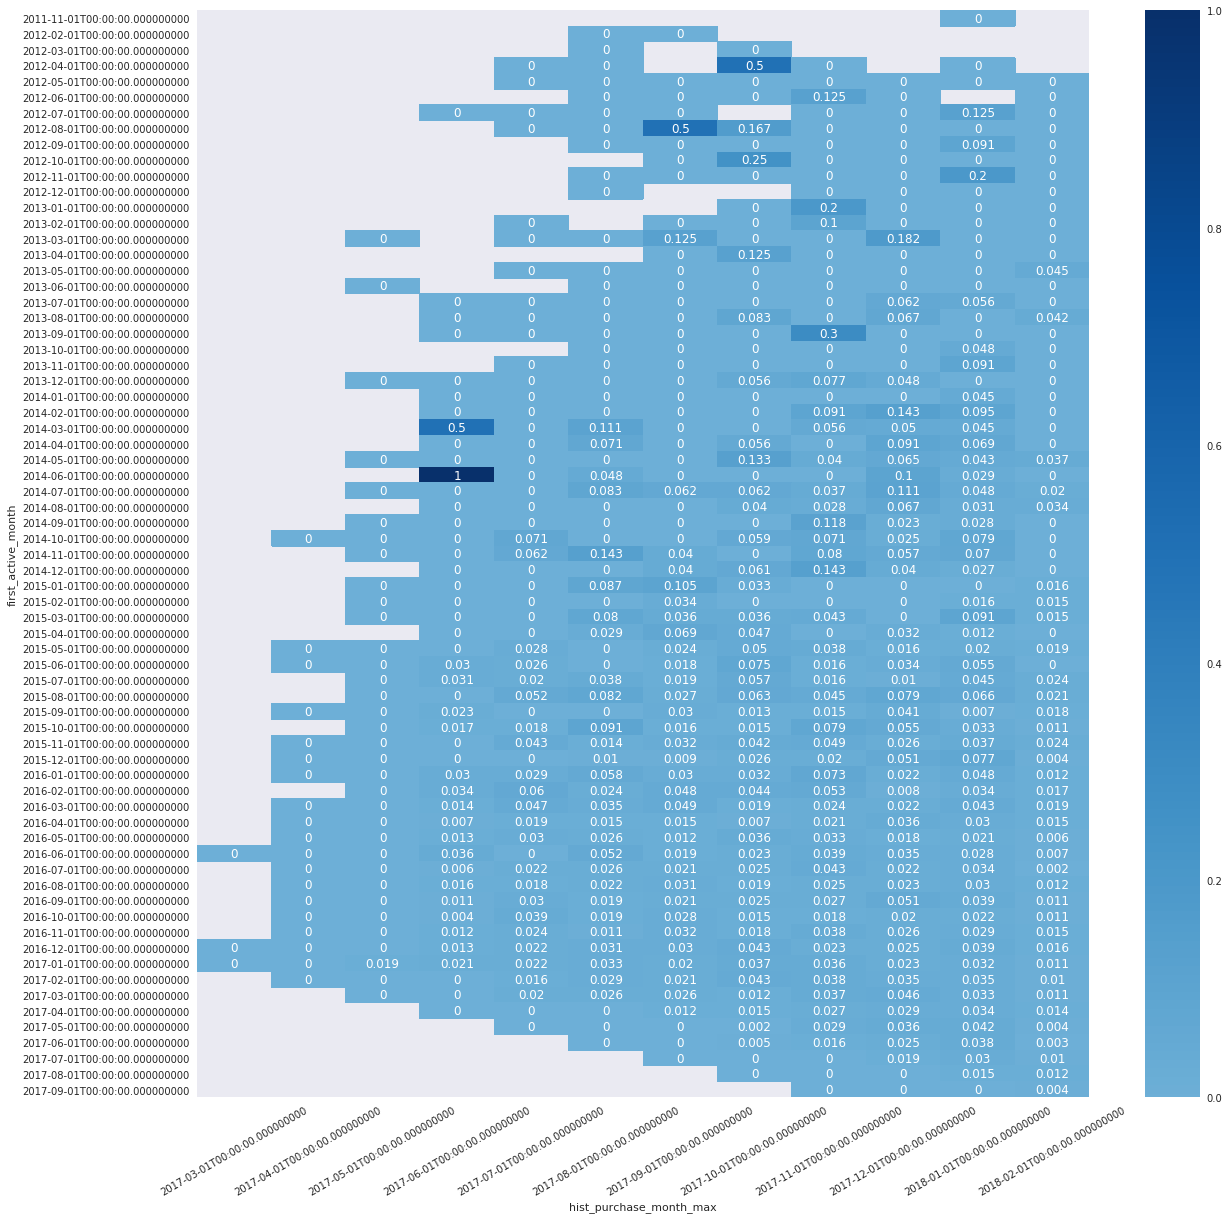

type: 1 | Count ID: 27732


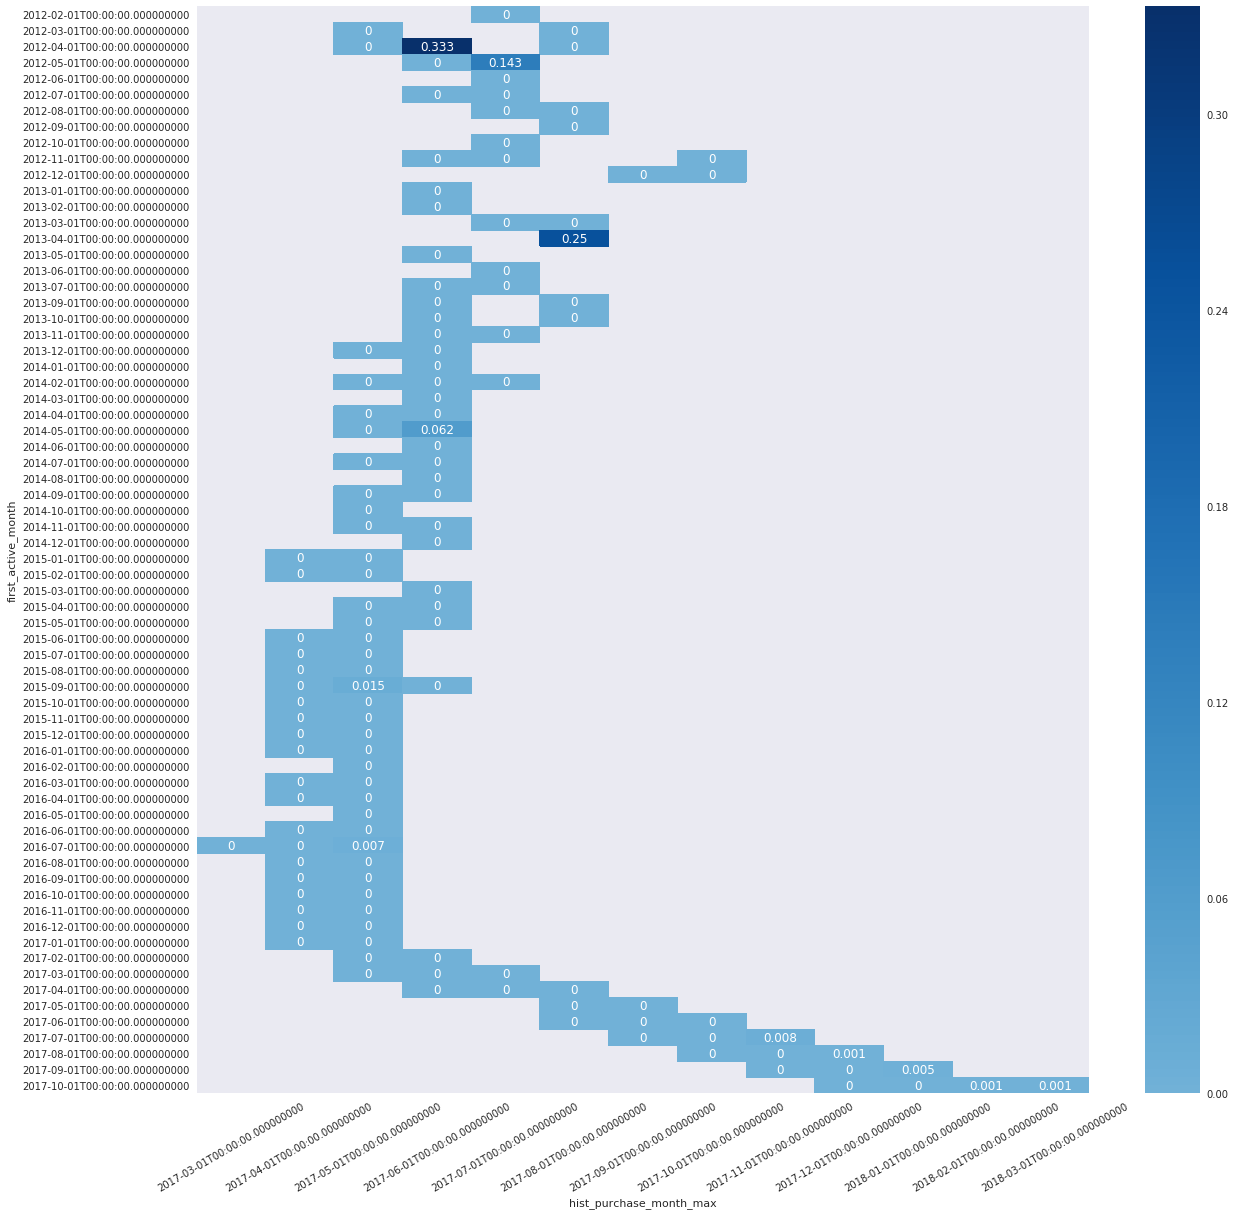

type: 2 | Count ID: 173539


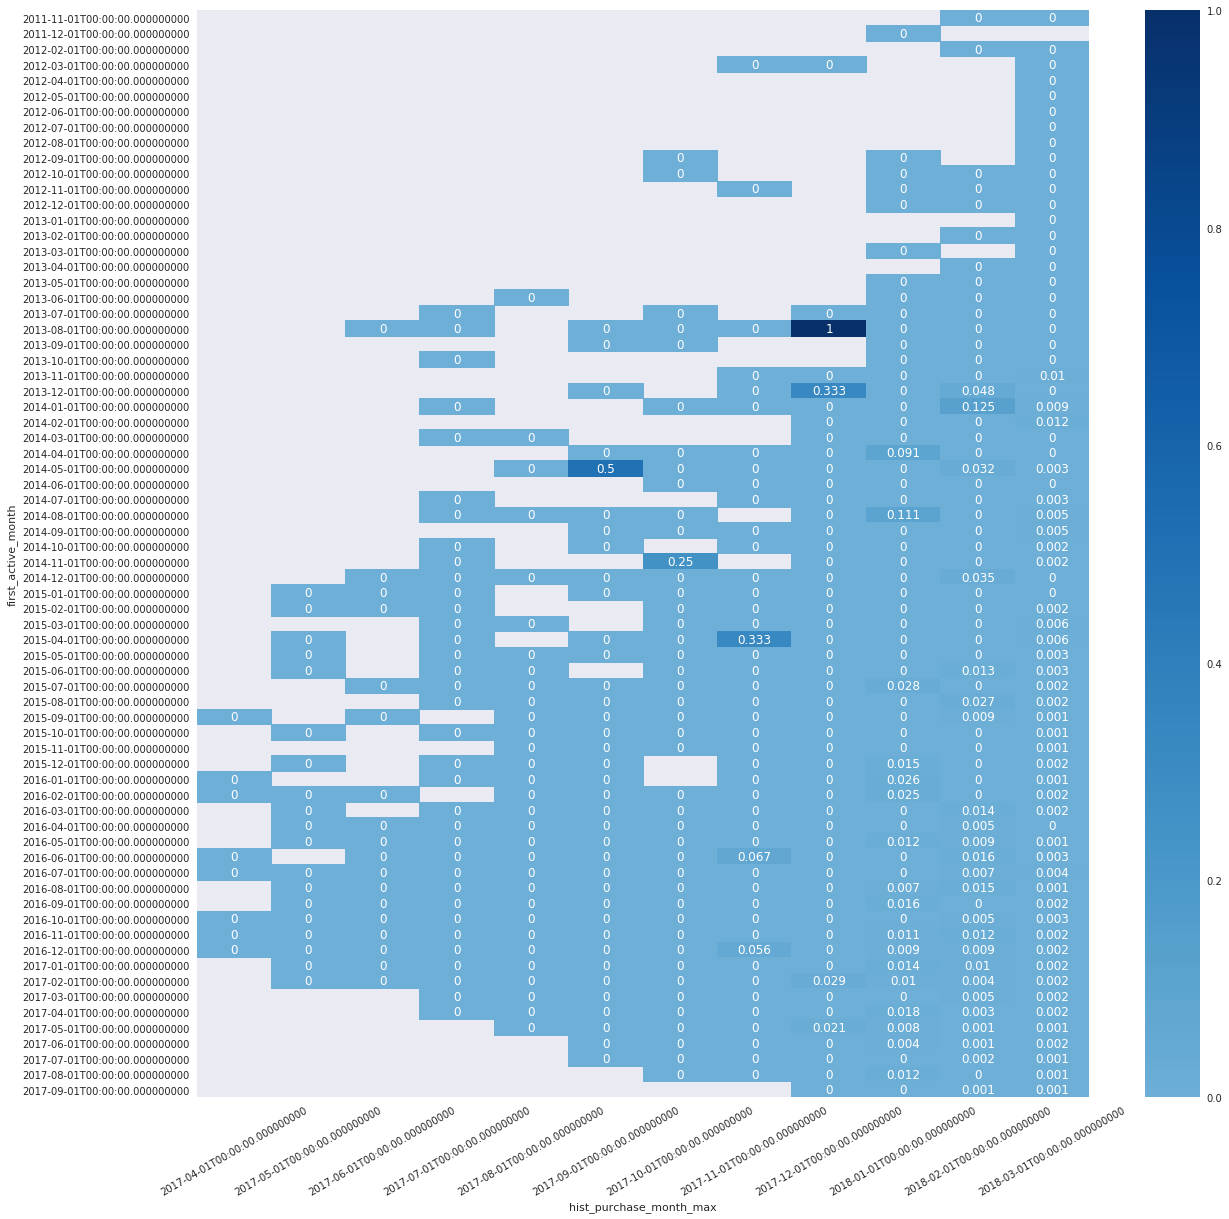

type: 10 | Count ID: 44844


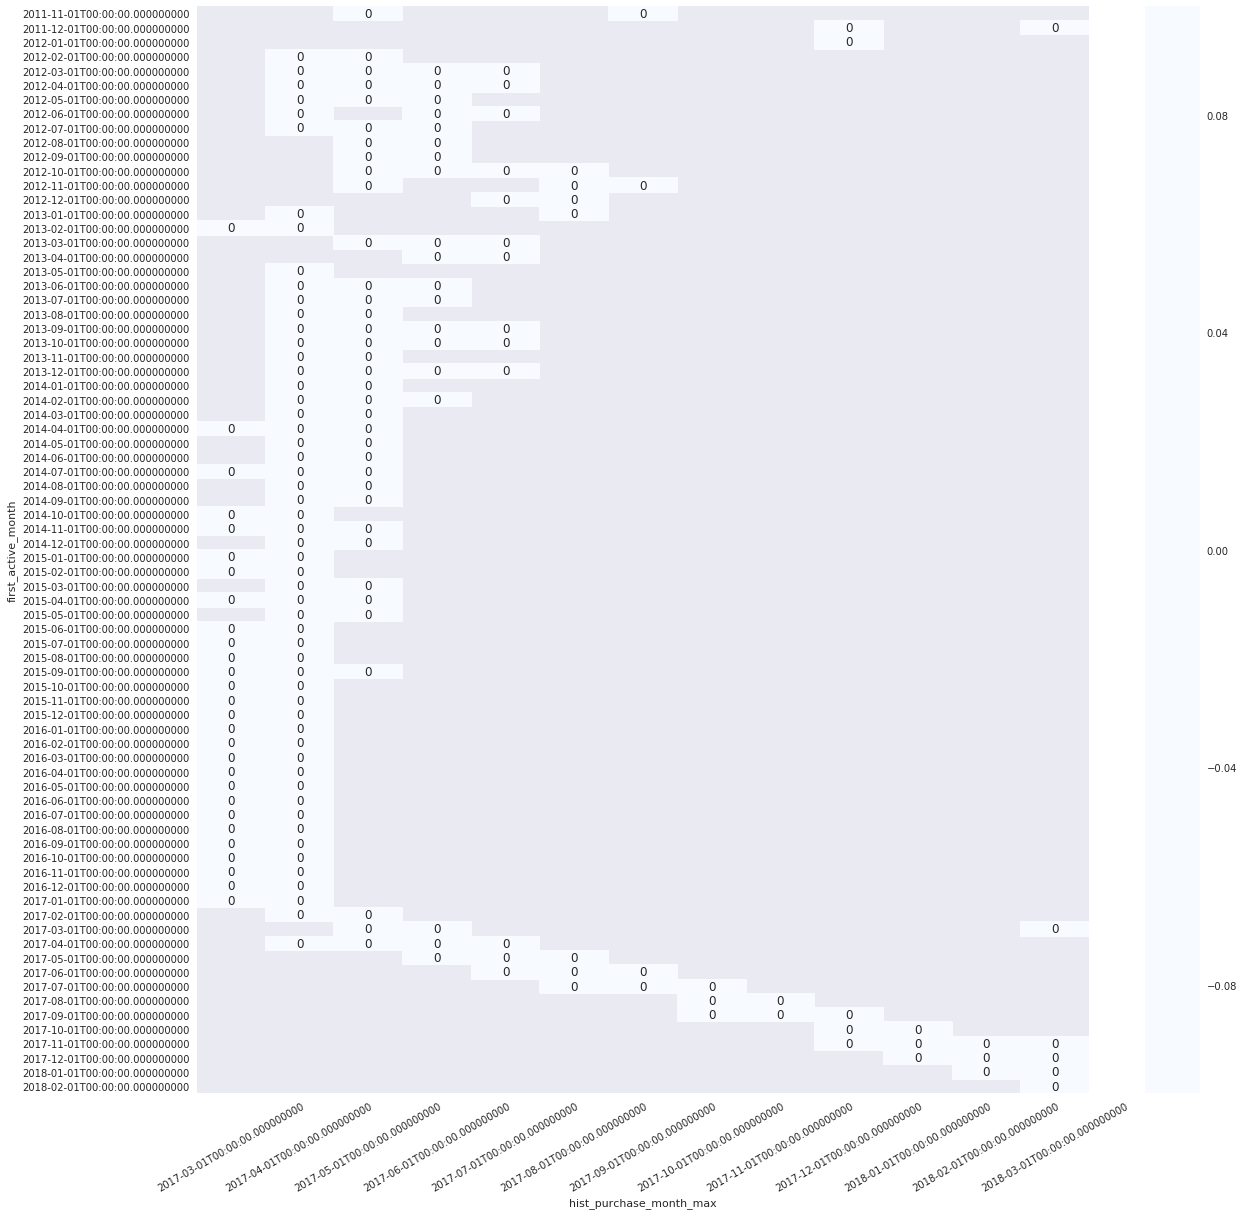

In [45]:
"""
hist_purchase_month_max = next_month of max(historical_purchase_date)
hist_regist_term = hist_purchase_month - first_active_month
"""

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
def get_new_columns(name,aggs):
#     return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

base['outlier'] = base[target].map(lambda x: 1 if x<-30 else 0)
type_list = np.sort(base['type'].unique())

for out_type in type_list:
    tmp_type = base[base['type']==out_type]
    cnt_id = np.array(tmp_type.index).shape[0]
    print(f"type: {out_type} | Count ID: {cnt_id}")
    aggs = {}
    aggs['card_id'] = ['size']
    aggs['outlier'] = ['sum']
    aggs['clf_pred'] = ['mean']
#     no_out_group = tmp_type.reset_index().groupby(['hist_regist_term', 'hist_purchase_month_max'])[['outlier', key]].agg(aggs)
    no_out_group = tmp_type.reset_index().groupby(['first_active_month', 'hist_purchase_month_max'])[['outlier', key, 'clf_pred']].agg(aggs)
    new_cols = get_new_columns('', aggs)
    no_out_group.columns = new_cols
    no_out_group['ratio'] = no_out_group['outlier_sum'] / no_out_group['card_id_size']
    no_out_group['ratio'] = no_out_group['ratio'].map(lambda x: np.round(x, 3))
    viz_1 = no_out_group['ratio'].unstack()
#     viz_2 = no_out_group['outlier_sum'].unstack()
#     no_out_group['clf_pred_mean'] = no_out_group['clf_pred_mean'].map(lambda x: np.round(x, 3))
#     viz_1 = no_out_group['clf_pred_mean'].unstack()
    
    # viz1
#     plt.figure(figsize=(20, 12))
    plt.figure(figsize=(20, 20))
    sns.heatmap(viz_1, center = 0.01, vmin=0, annot=True, fmt='g', cmap='Blues')
    plt.xticks(rotation='30')
    plt.show()
    # viz2
#     plt.figure(figsize=(20, 12))
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(viz_2, center = 10, vmin=0, annot=True, fmt='g', cmap='Blues')
#     plt.xticks(rotation='30')
#     plt.show()

## Target Distribution
Visualized for each group(by first_active_month and hist_regist_term)  
each group target is almost normal distribution.

first_active_month: 2017-09-01 00:00:00 | hist_regist_term: 3
target max: 5.18016514 | min:-9.33382952


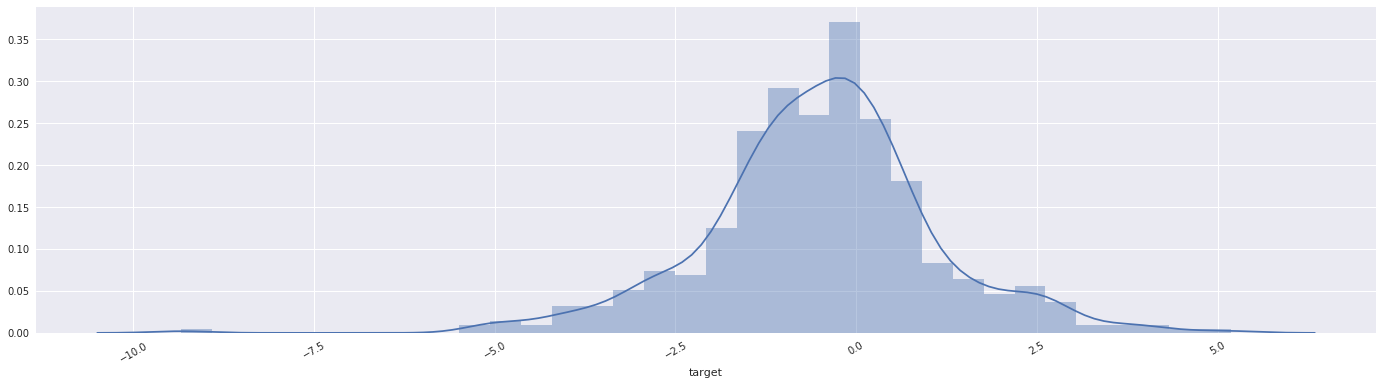

first_active_month: 2017-10-01 00:00:00 | hist_regist_term: 3
target max: 6.60822801 | min:-5.4006286


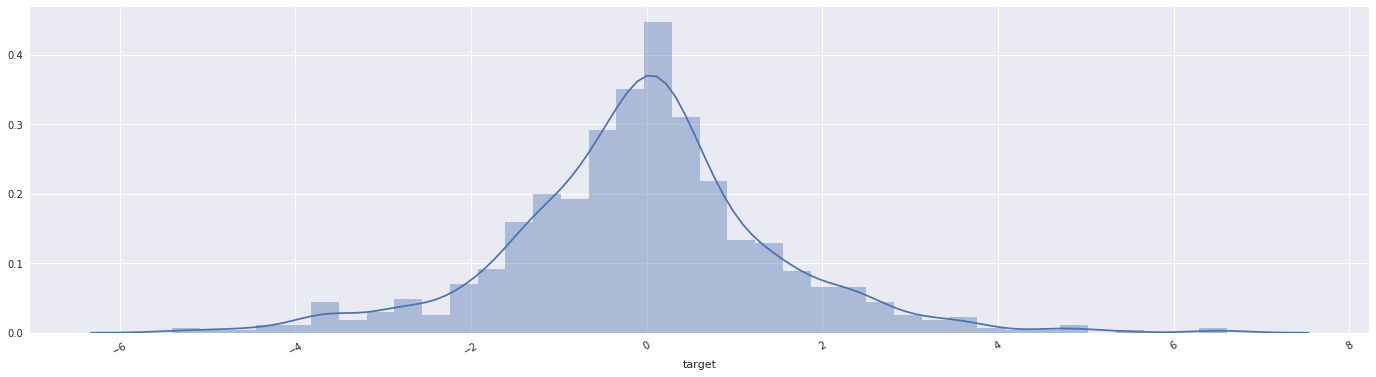

first_active_month: 2017-11-01 00:00:00 | hist_regist_term: 3
target max: 7.47372184 | min:-8.34798847


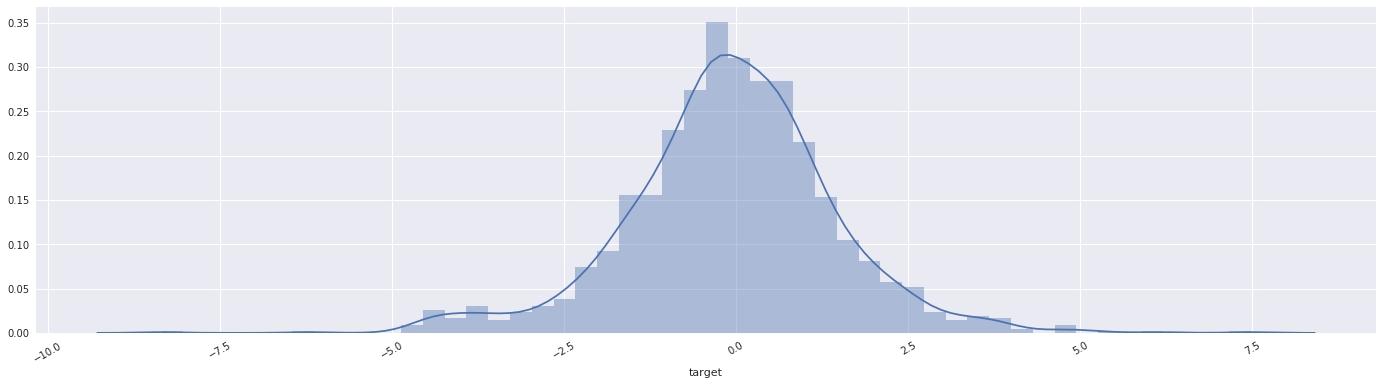

first_active_month: 2017-12-01 00:00:00 | hist_regist_term: 3
target max: 8.22246197 | min:-8.10846098


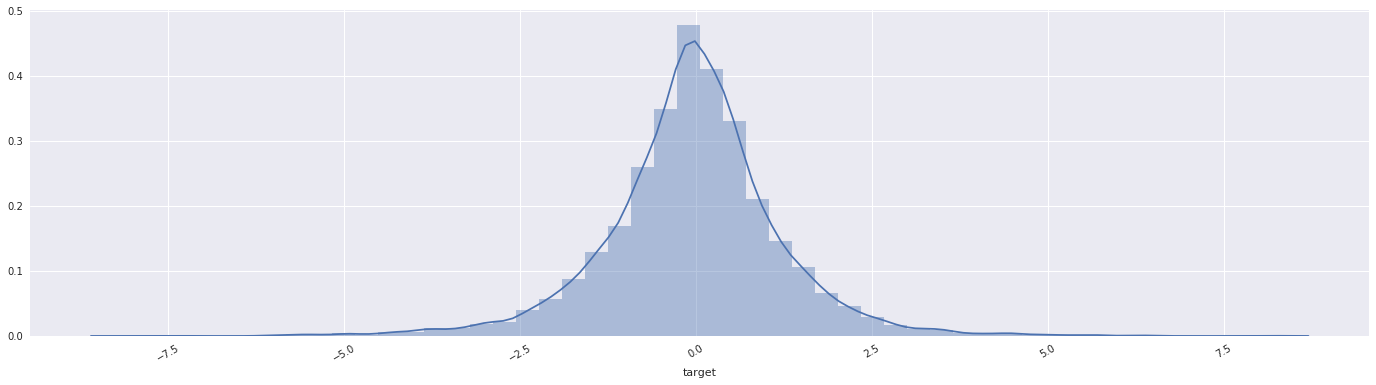

first_active_month: 2017-08-01 00:00:00 | hist_regist_term: 4
target max: 6.95495236 | min:-33.21928095


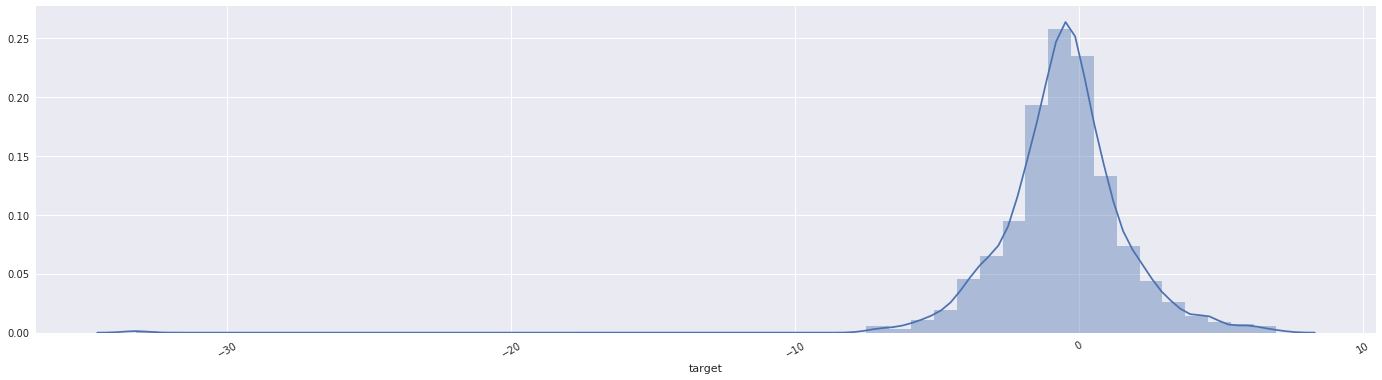

first_active_month: 2017-09-01 00:00:00 | hist_regist_term: 4
target max: 8.88473745 | min:-33.21928095


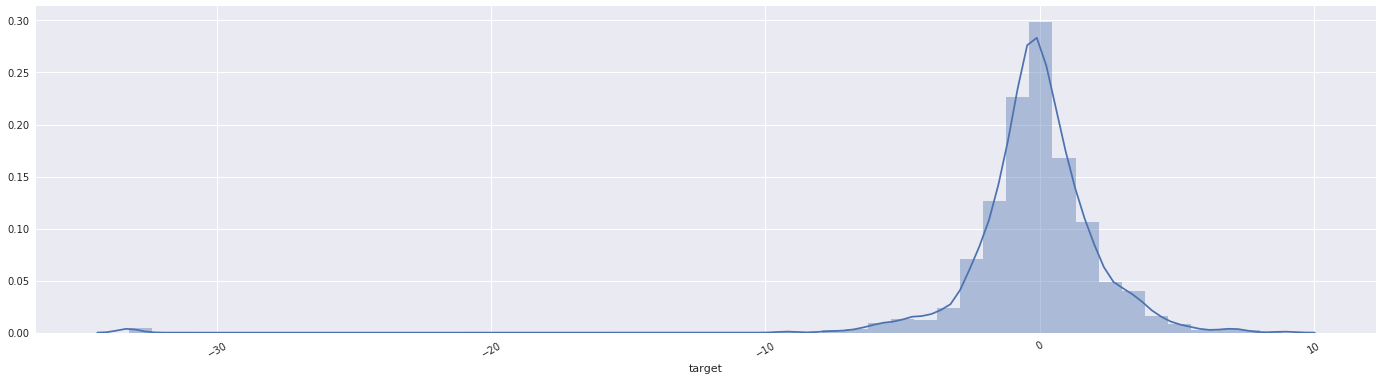

first_active_month: 2017-10-01 00:00:00 | hist_regist_term: 4
target max: 12.97039354 | min:-33.21928095


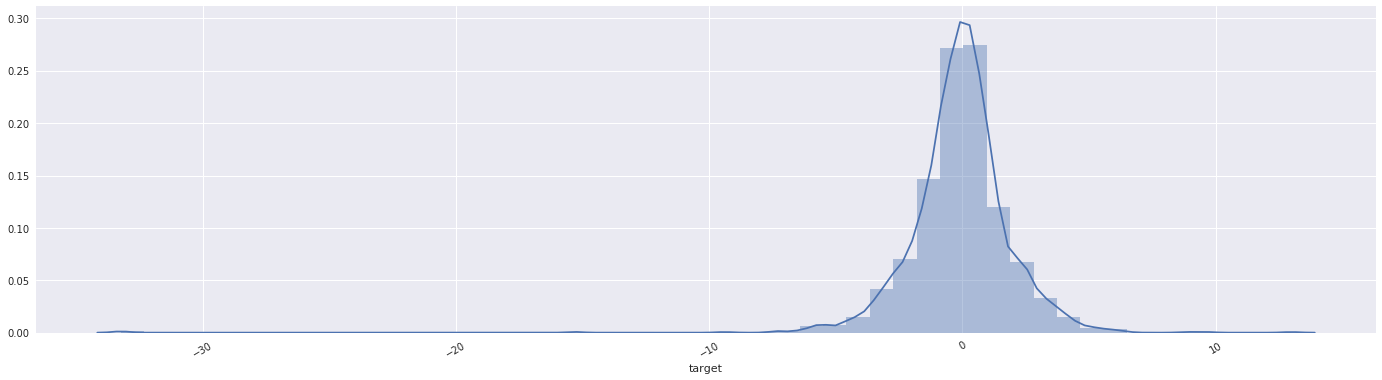

first_active_month: 2017-11-01 00:00:00 | hist_regist_term: 4
target max: 11.6065579 | min:-14.03637397


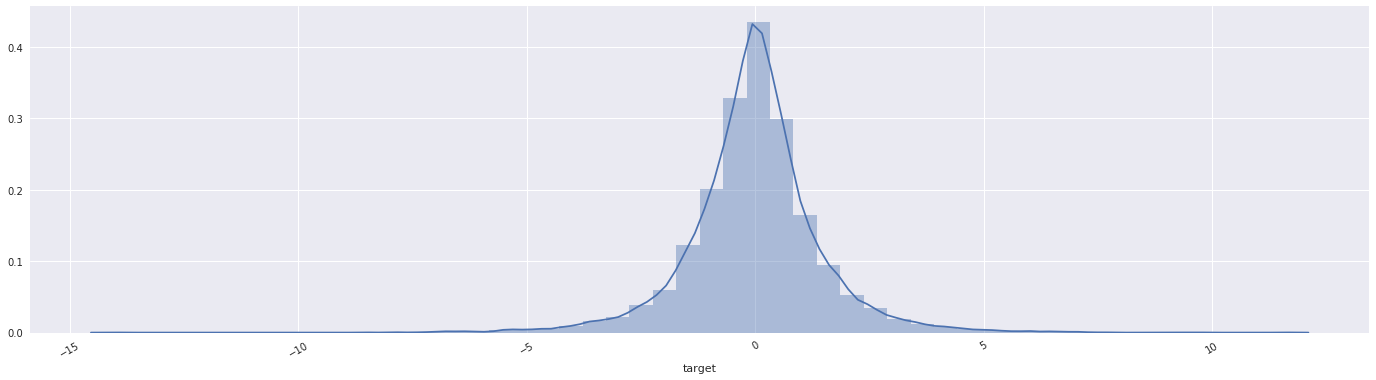

first_active_month: 2017-07-01 00:00:00 | hist_regist_term: 5
target max: 7.33446995 | min:-33.21928095


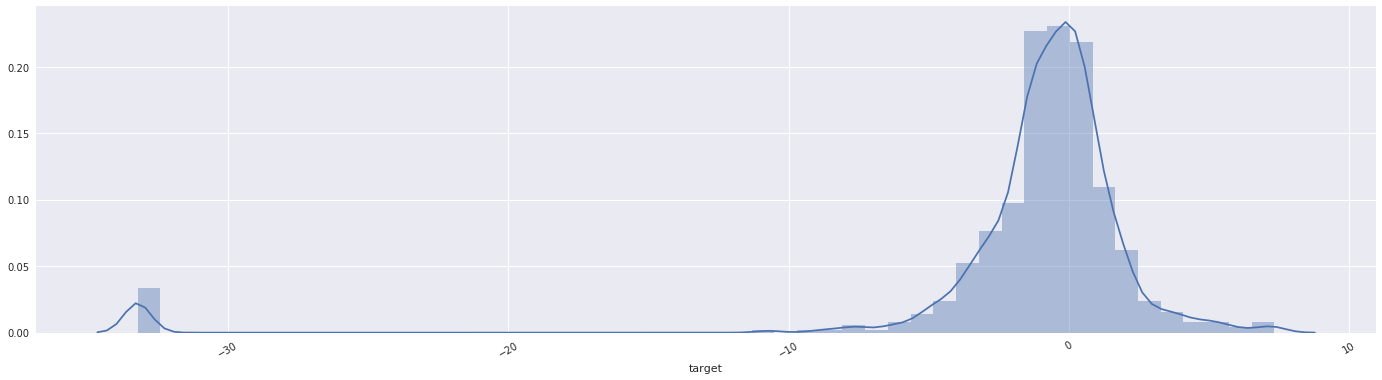

first_active_month: 2017-08-01 00:00:00 | hist_regist_term: 5
target max: 12.44630793 | min:-33.21928095


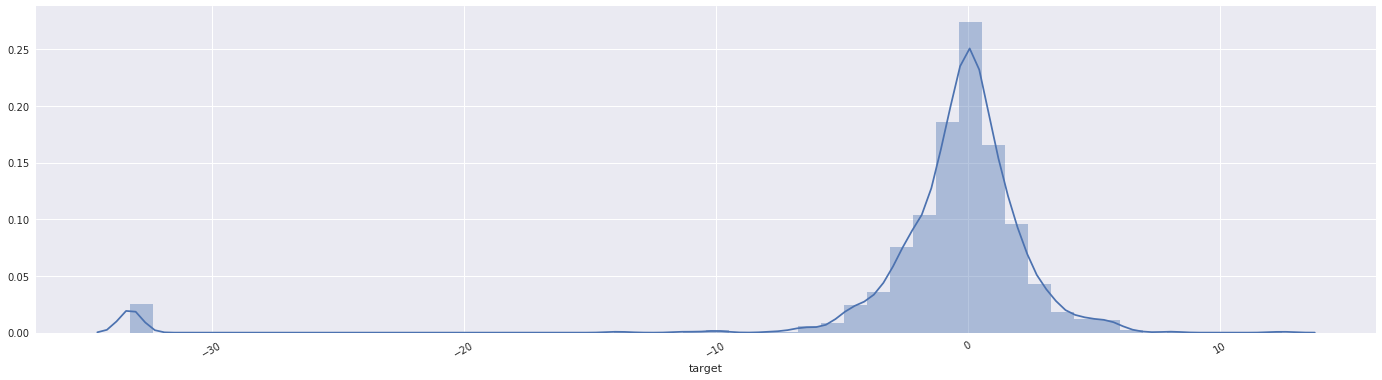

first_active_month: 2017-09-01 00:00:00 | hist_regist_term: 5
target max: 11.8864587 | min:-33.21928095


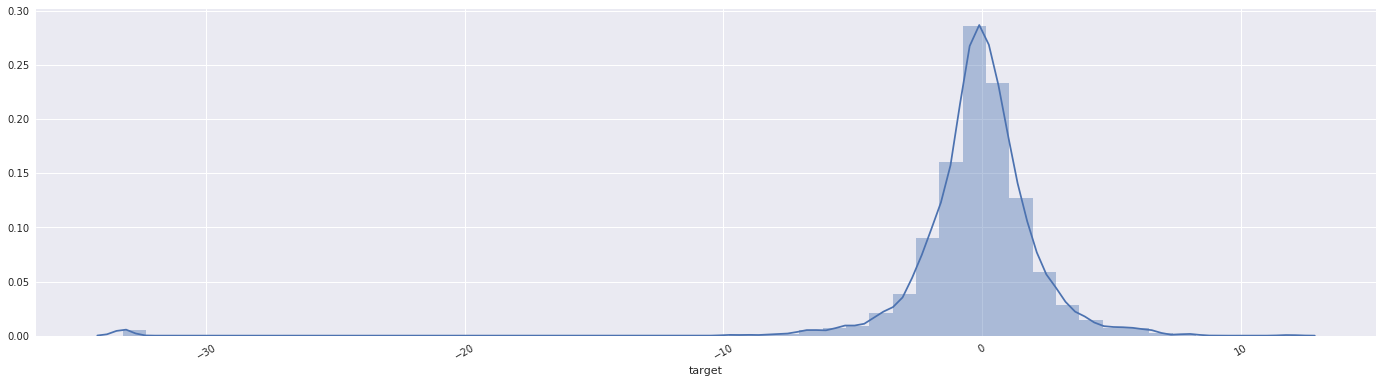

first_active_month: 2017-10-01 00:00:00 | hist_regist_term: 5
target max: 10.1391048 | min:-33.21928095


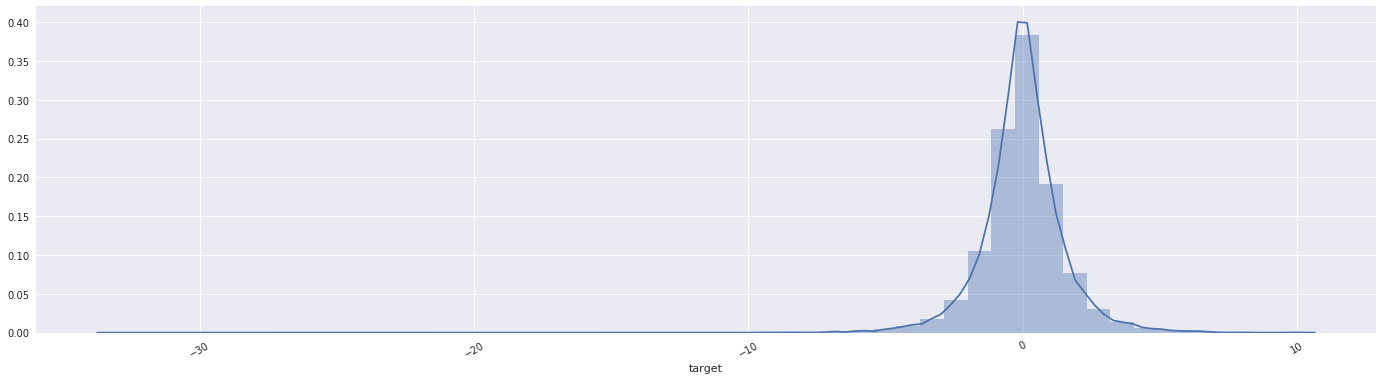

first_active_month: 2017-06-01 00:00:00 | hist_regist_term: 6
target max: 7.93663794 | min:-33.21928095


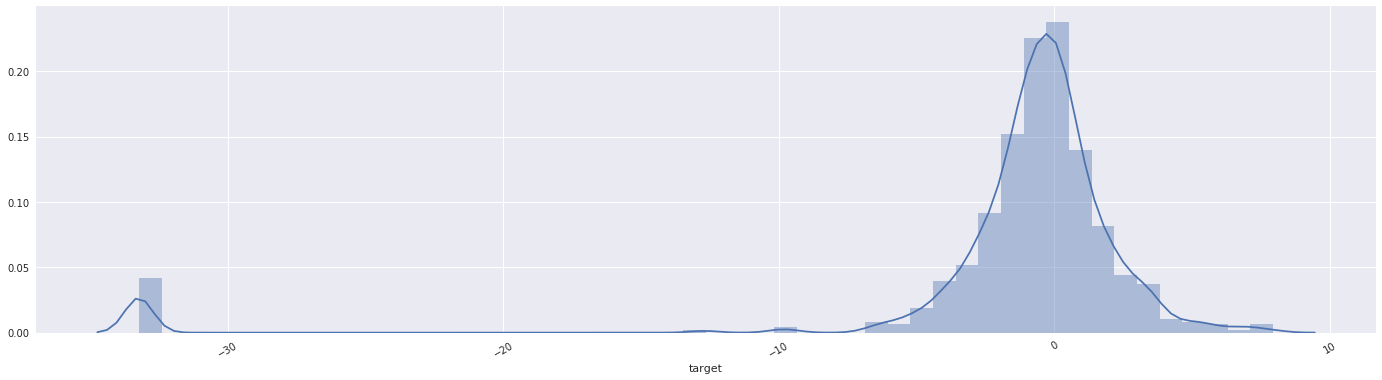

first_active_month: 2017-07-01 00:00:00 | hist_regist_term: 6
target max: 8.64024494 | min:-33.21928095


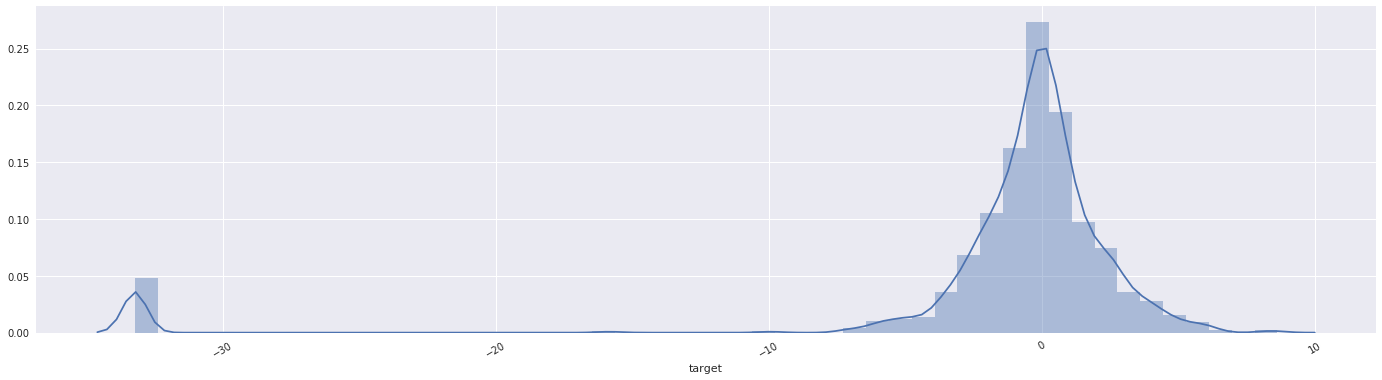

first_active_month: 2017-08-01 00:00:00 | hist_regist_term: 6
target max: 13.60987129 | min:-33.21928095


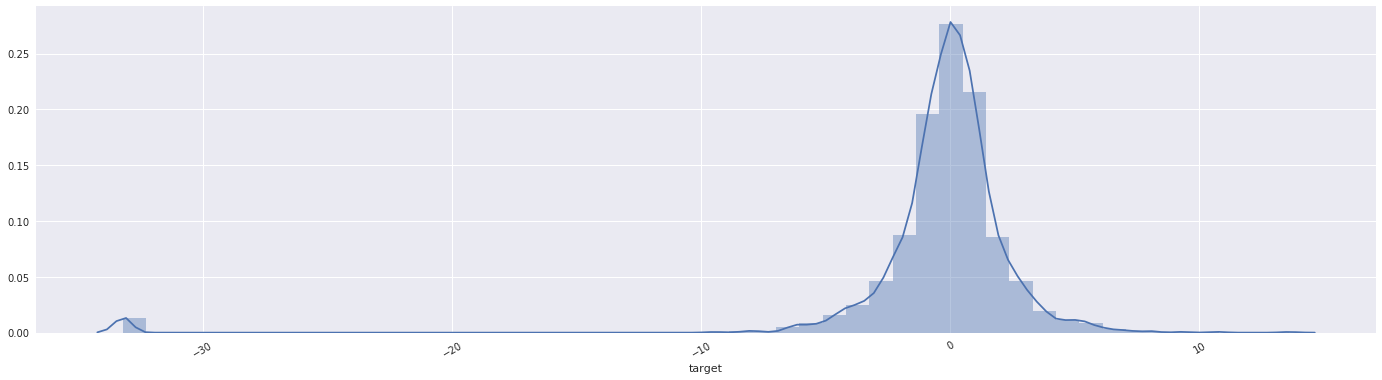

first_active_month: 2017-09-01 00:00:00 | hist_regist_term: 6
target max: 13.60232191 | min:-33.21928095


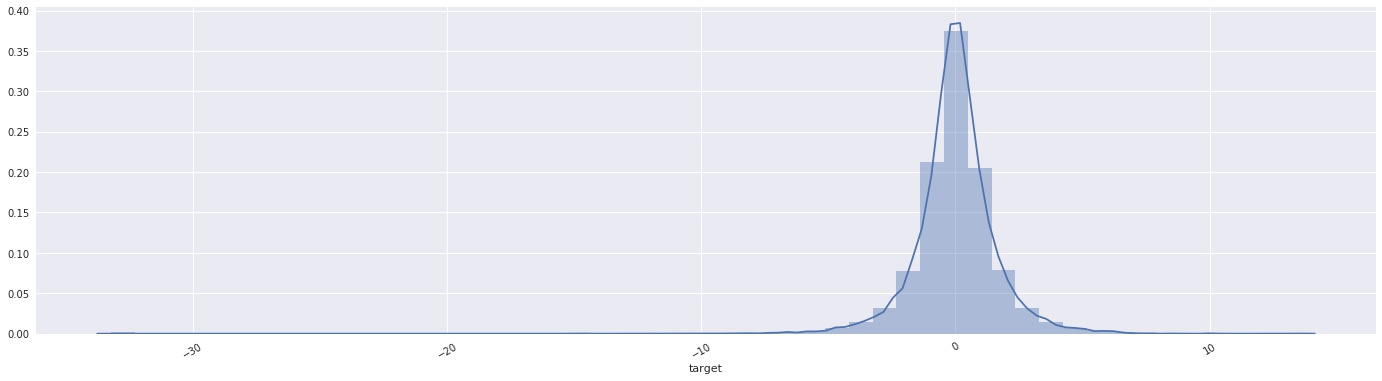

first_active_month: 2017-06-01 00:00:00 | hist_regist_term: 7
target max: 10.25738784 | min:-33.21928095


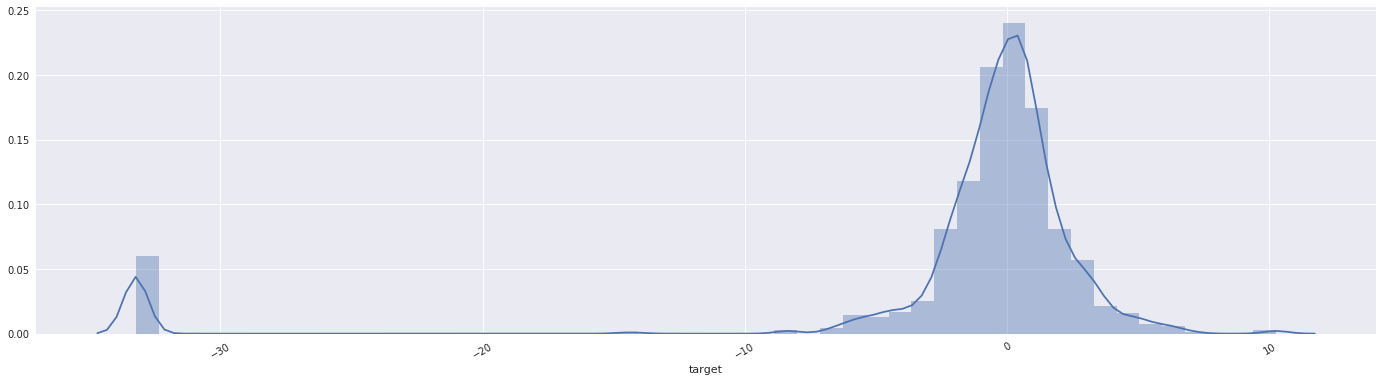

first_active_month: 2017-07-01 00:00:00 | hist_regist_term: 7
target max: 8.63023881 | min:-33.21928095


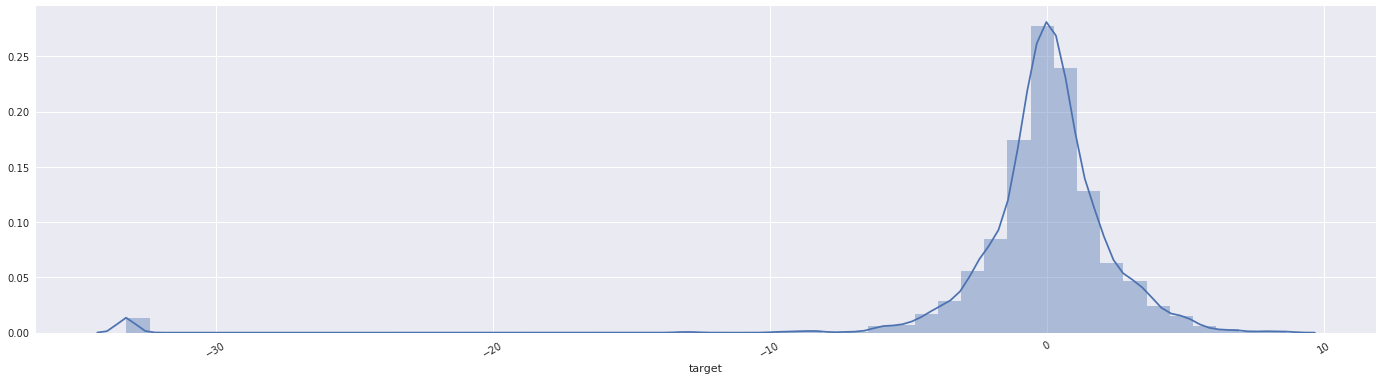

first_active_month: 2017-08-01 00:00:00 | hist_regist_term: 7
target max: 14.85516048 | min:-33.21928095


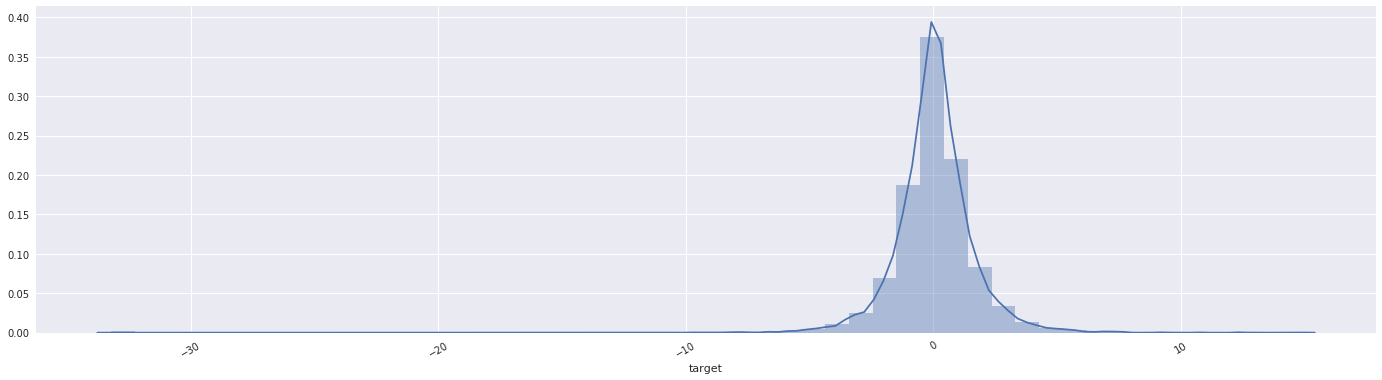

first_active_month: 2017-05-01 00:00:00 | hist_regist_term: 8
target max: 7.87815312 | min:-33.21928095


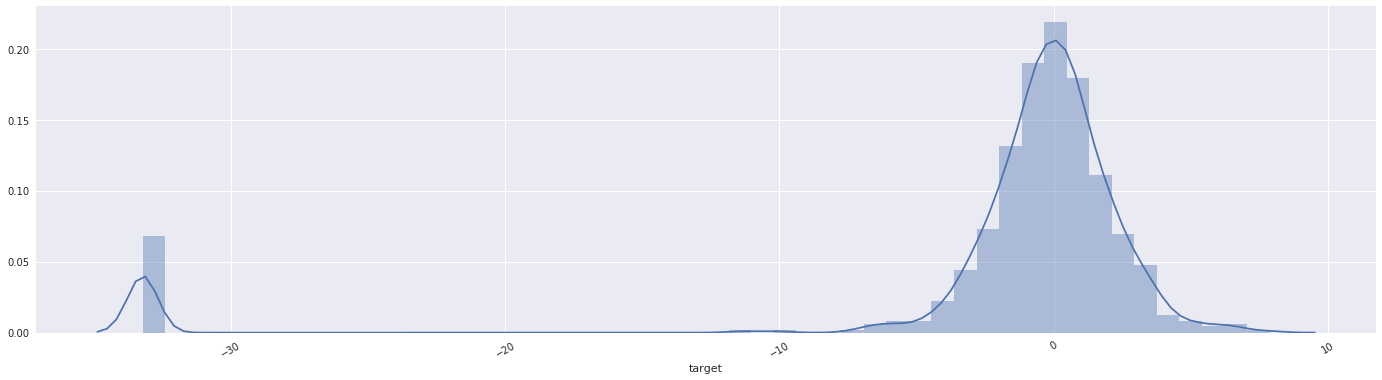

first_active_month: 2017-06-01 00:00:00 | hist_regist_term: 8
target max: 13.31061278 | min:-33.21928095


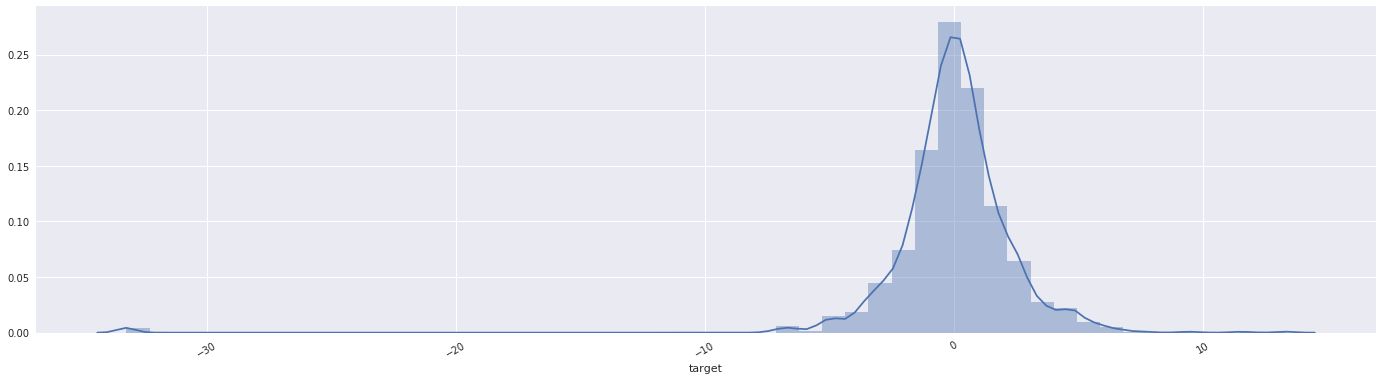

first_active_month: 2017-07-01 00:00:00 | hist_regist_term: 8
target max: 9.18755003 | min:-33.21928095


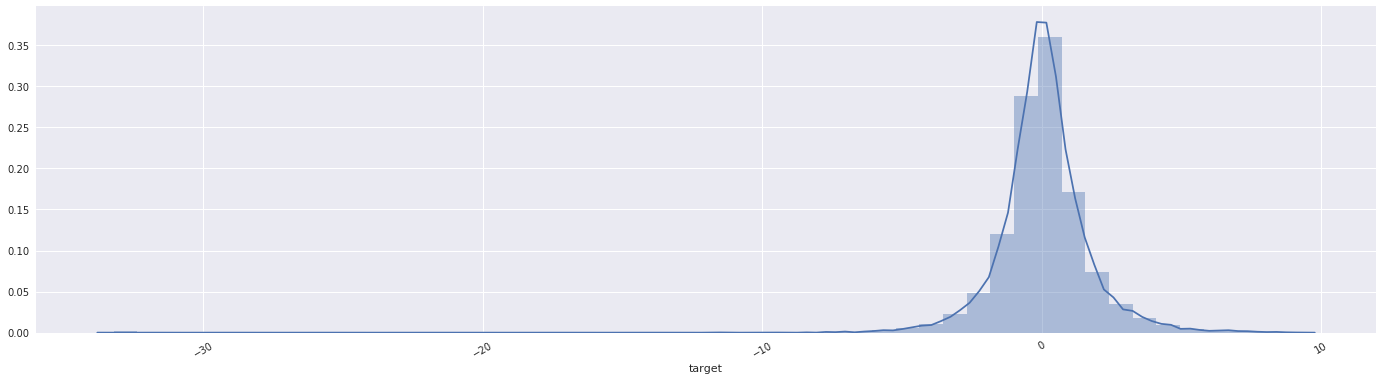

first_active_month: 2017-04-01 00:00:00 | hist_regist_term: 9
target max: 8.01407085 | min:-33.21928095


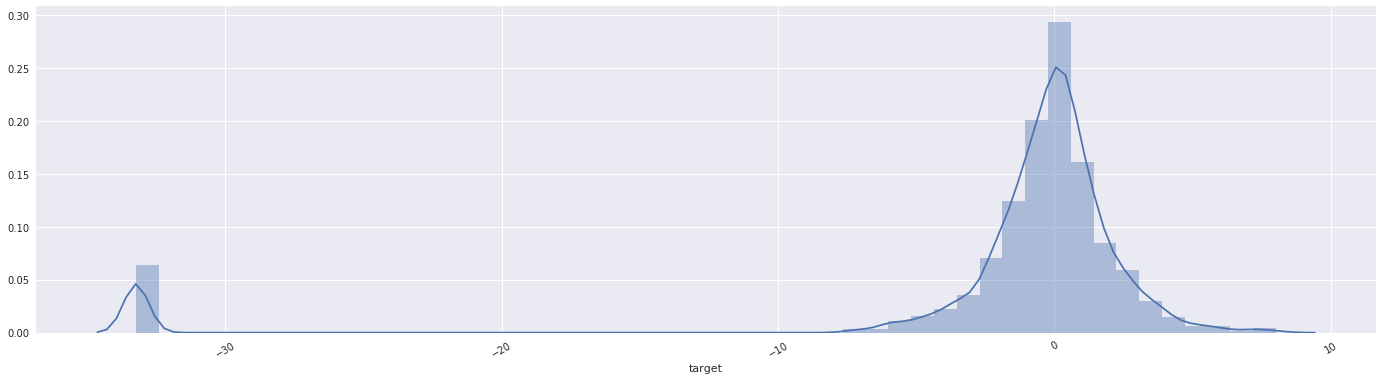

first_active_month: 2017-05-01 00:00:00 | hist_regist_term: 9
target max: 17.9650684 | min:-33.21928095


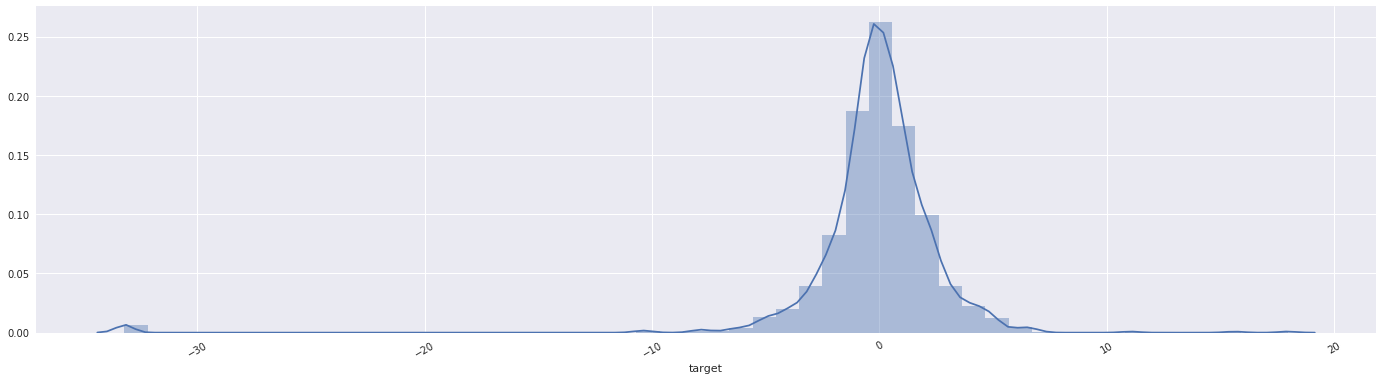

first_active_month: 2017-06-01 00:00:00 | hist_regist_term: 9
target max: 11.60157582 | min:-33.21928095


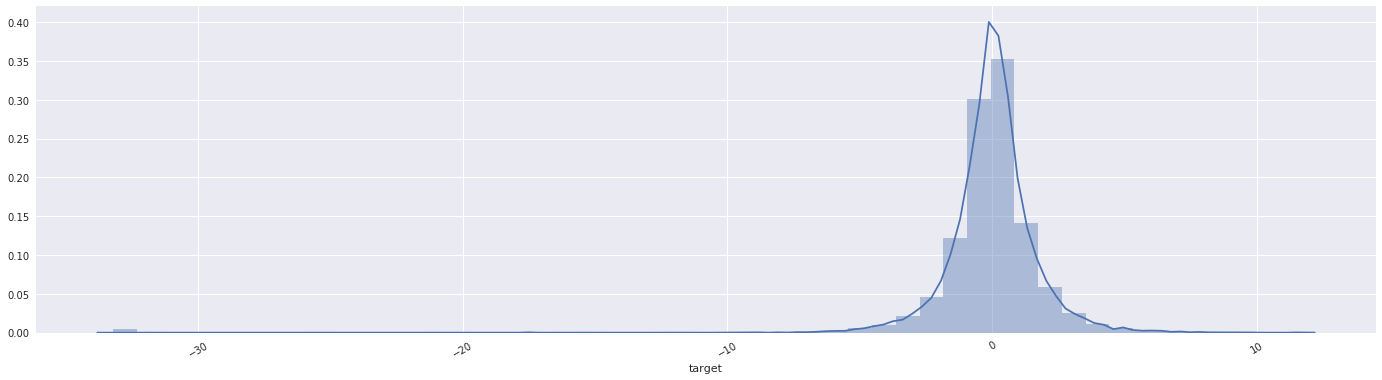

first_active_month: 2017-03-01 00:00:00 | hist_regist_term: 10
target max: 8.0871075 | min:-33.21928095


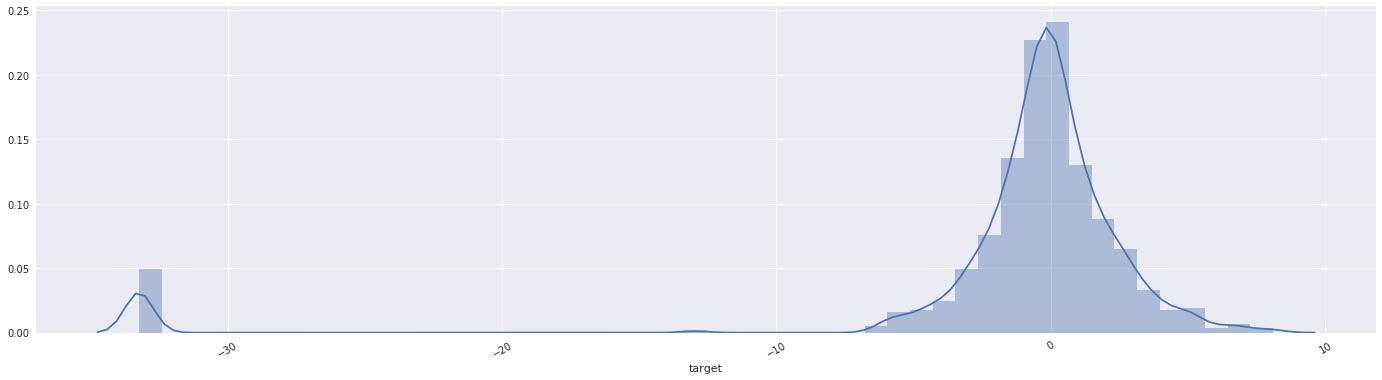

first_active_month: 2017-04-01 00:00:00 | hist_regist_term: 10
target max: 9.86983019 | min:-33.21928095


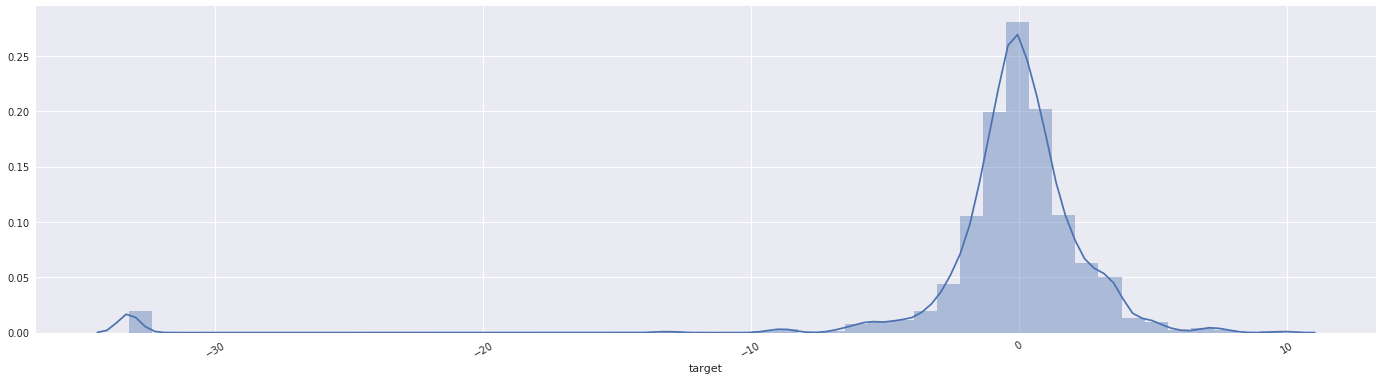

first_active_month: 2017-05-01 00:00:00 | hist_regist_term: 10
target max: 10.18882371 | min:-33.21928095


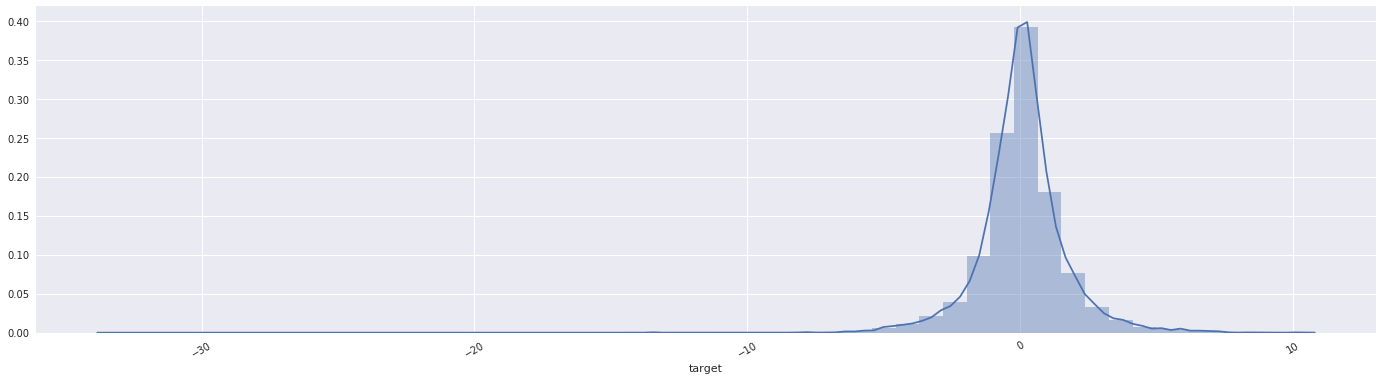

first_active_month: 2016-12-01 00:00:00 | hist_regist_term: 11
target max: 9.94137045 | min:-33.21928095


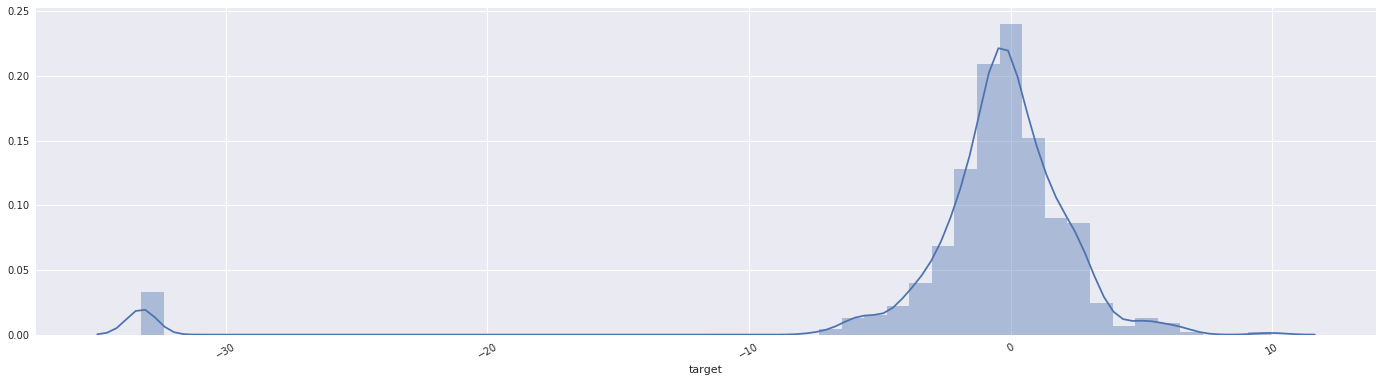

first_active_month: 2017-02-01 00:00:00 | hist_regist_term: 11
target max: 15.99445509 | min:-33.21928095


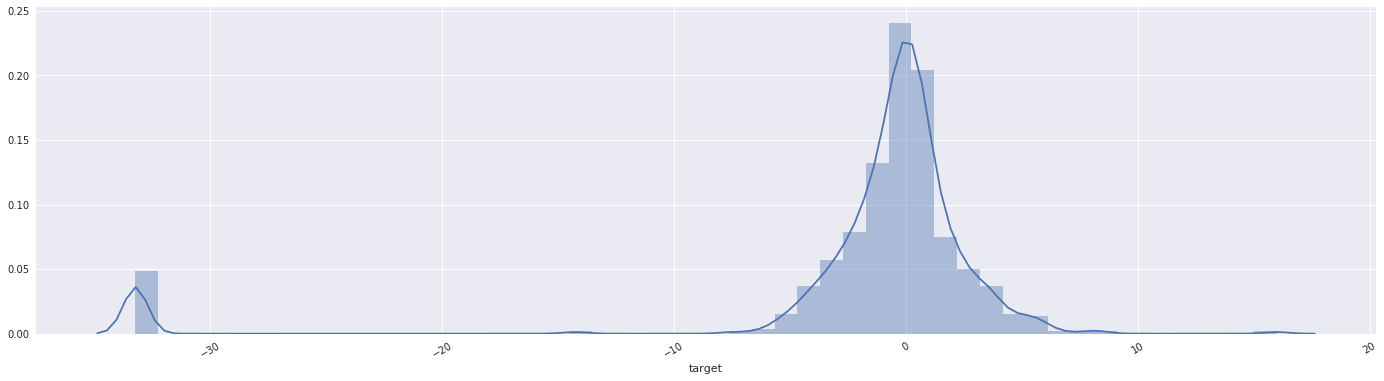

first_active_month: 2017-03-01 00:00:00 | hist_regist_term: 11
target max: 8.92204915 | min:-33.21928095


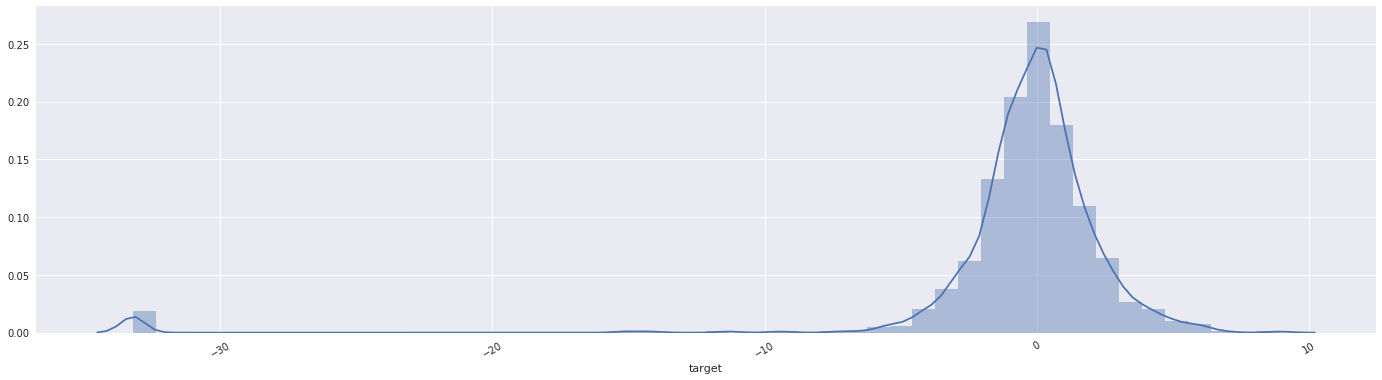

first_active_month: 2017-04-01 00:00:00 | hist_regist_term: 11
target max: 10.20104569 | min:-33.21928095


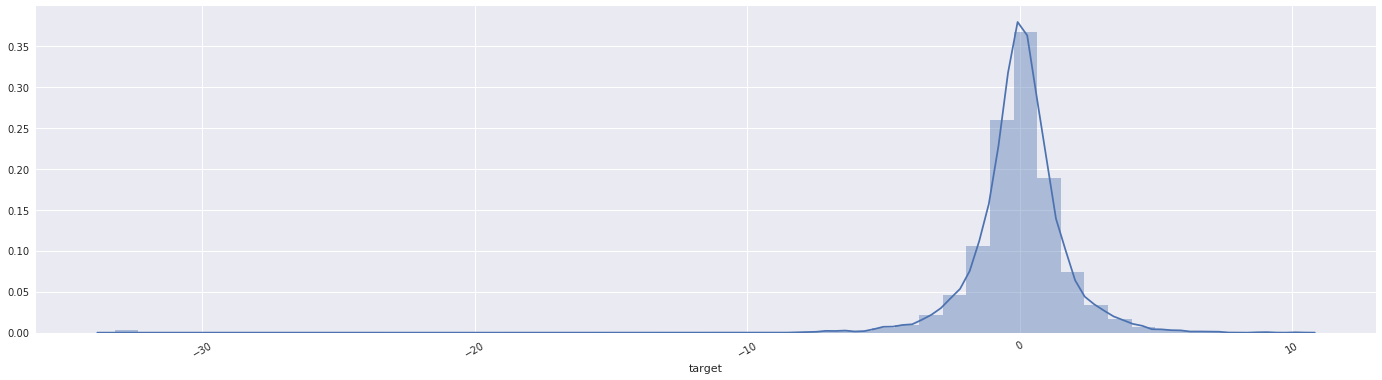

first_active_month: 2016-11-01 00:00:00 | hist_regist_term: 12
target max: 10.57183554 | min:-33.21928095


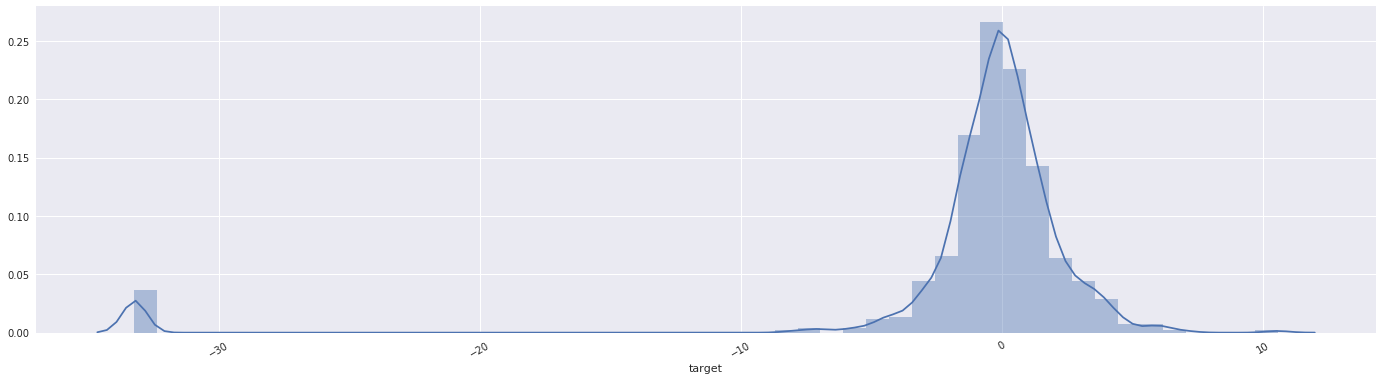

first_active_month: 2016-12-01 00:00:00 | hist_regist_term: 12
target max: 11.29157987 | min:-33.21928095


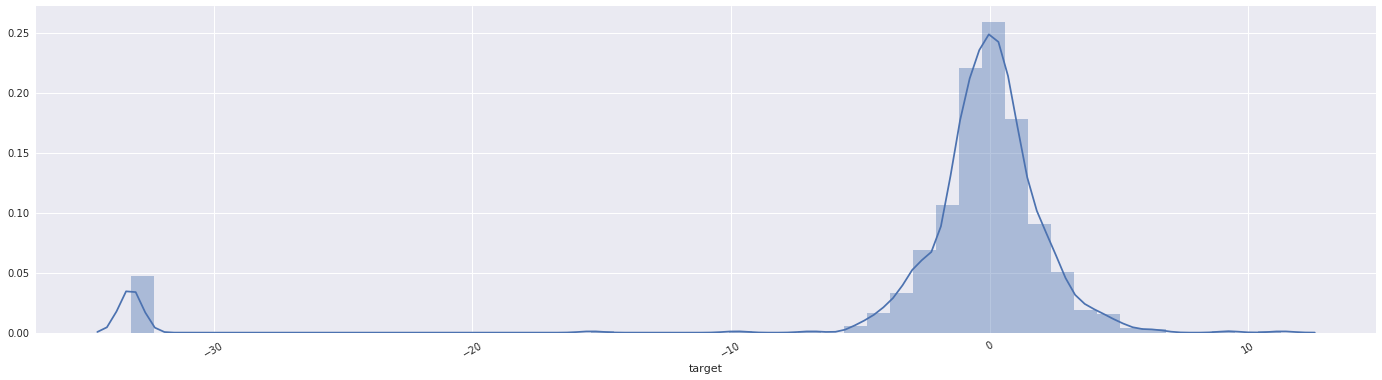

first_active_month: 2017-01-01 00:00:00 | hist_regist_term: 12
target max: 9.01564533 | min:-33.21928095


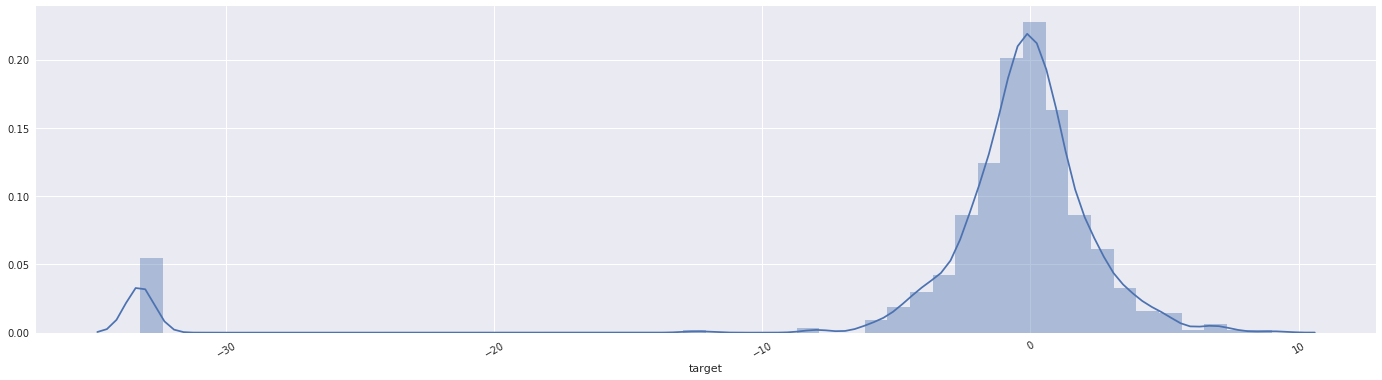

first_active_month: 2017-02-01 00:00:00 | hist_regist_term: 12
target max: 7.30378075 | min:-33.21928095


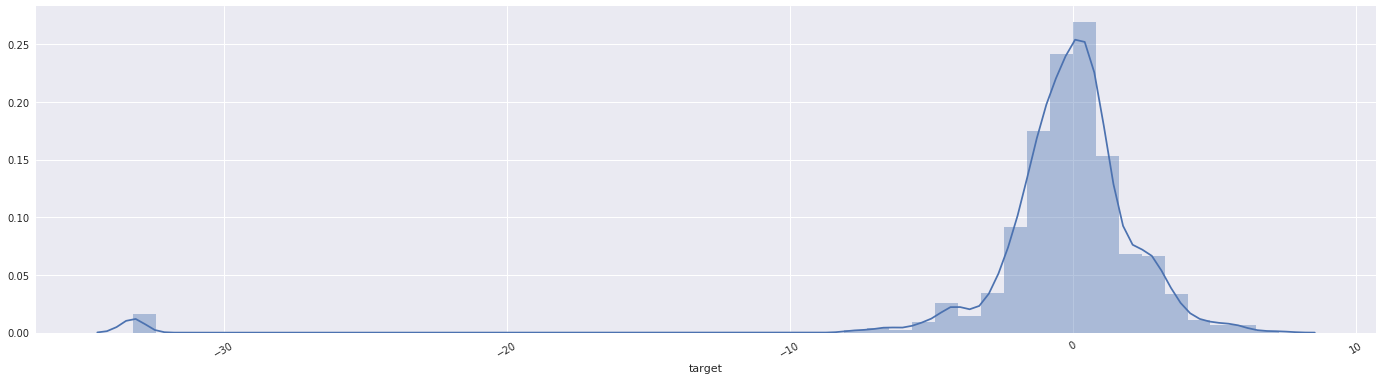

first_active_month: 2017-03-01 00:00:00 | hist_regist_term: 12
target max: 12.74399286 | min:-33.21928095


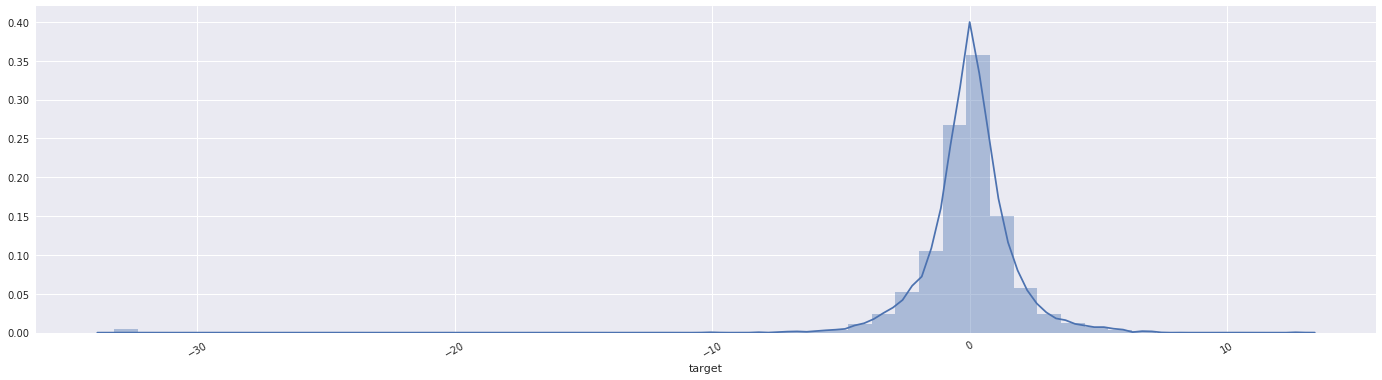

first_active_month: 2016-06-01 00:00:00 | hist_regist_term: 13
target max: 8.59356986 | min:-33.21928095


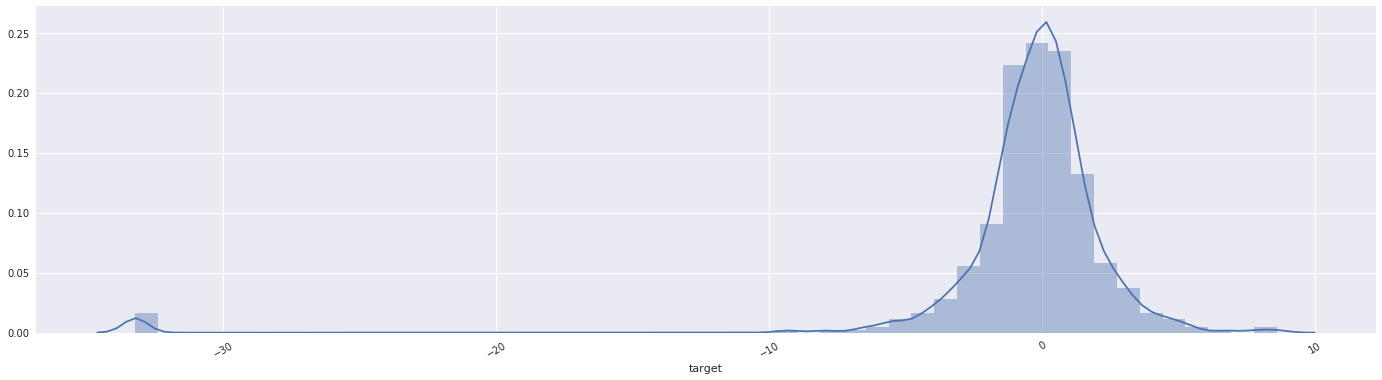

first_active_month: 2016-08-01 00:00:00 | hist_regist_term: 13
target max: 7.69154759 | min:-33.21928095


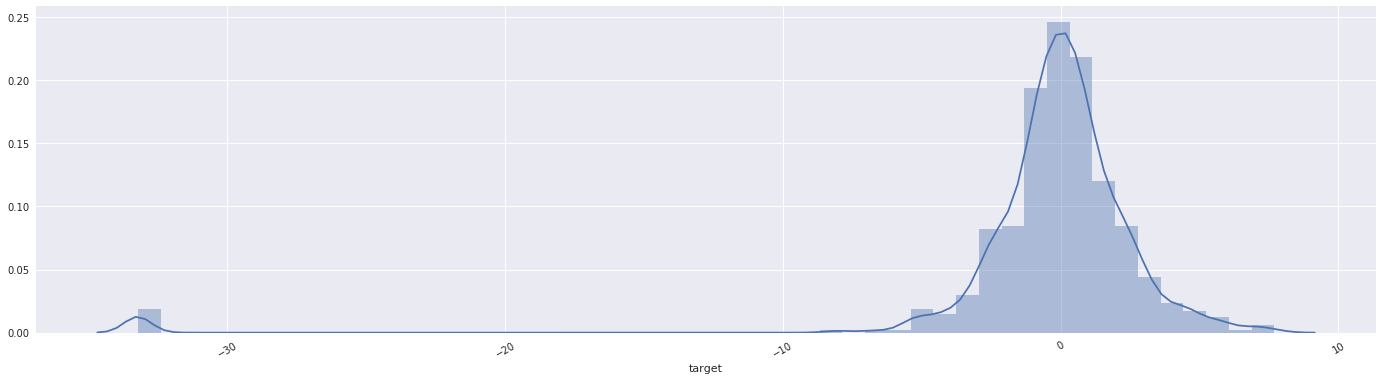

first_active_month: 2016-09-01 00:00:00 | hist_regist_term: 13
target max: 5.8715192 | min:-33.21928095


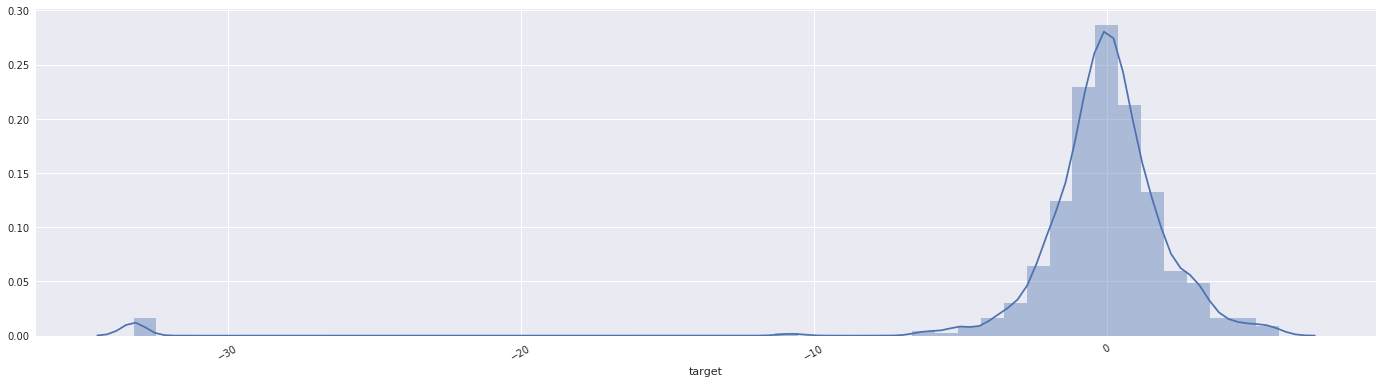

first_active_month: 2016-10-01 00:00:00 | hist_regist_term: 13
target max: 6.58056985 | min:-33.21928095


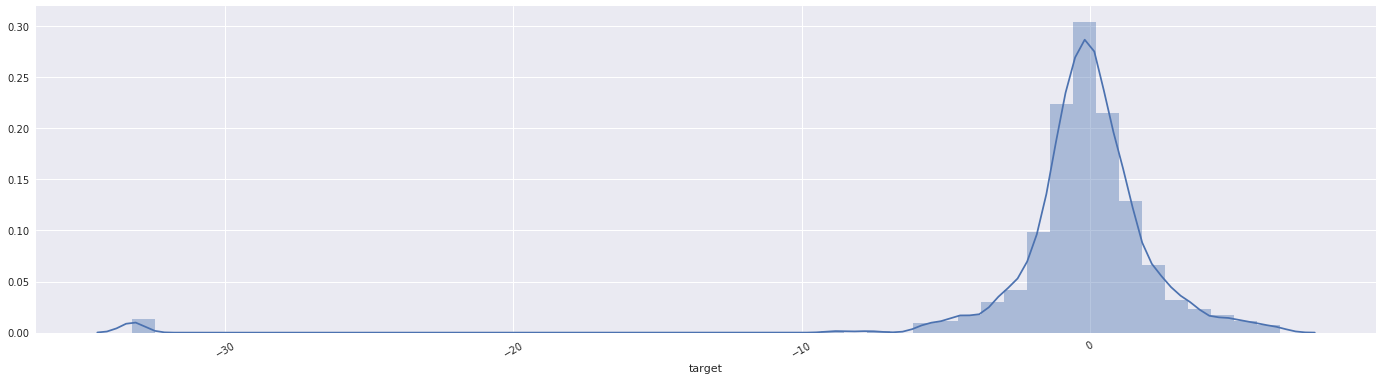

first_active_month: 2016-11-01 00:00:00 | hist_regist_term: 13
target max: 15.29462075 | min:-33.21928095


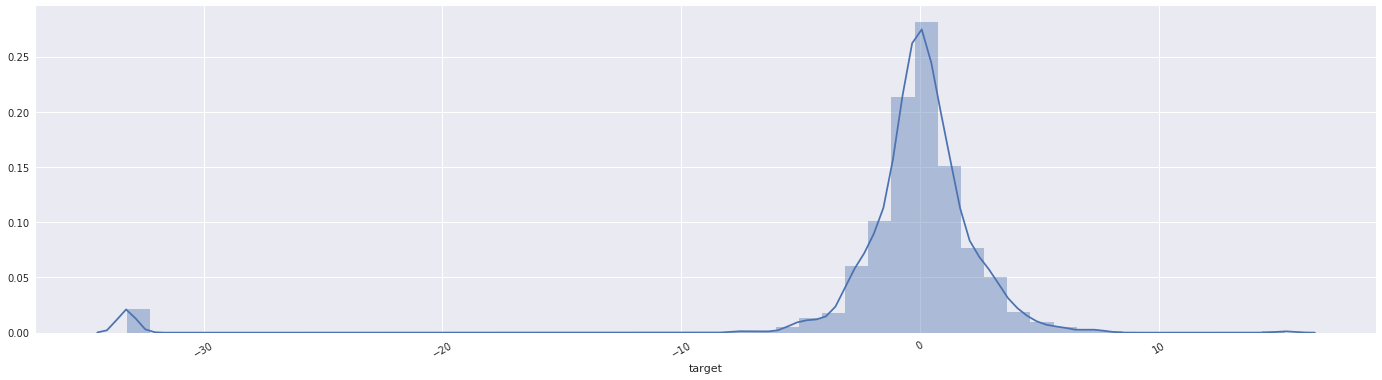

first_active_month: 2016-12-01 00:00:00 | hist_regist_term: 13
target max: 13.59222342 | min:-33.21928095


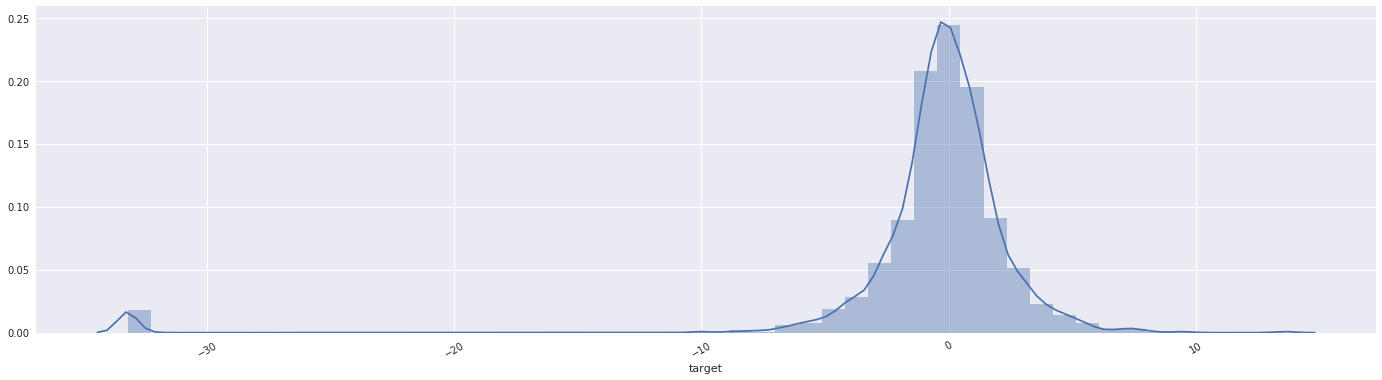

first_active_month: 2017-01-01 00:00:00 | hist_regist_term: 13
target max: 15.01135831 | min:-33.21928095


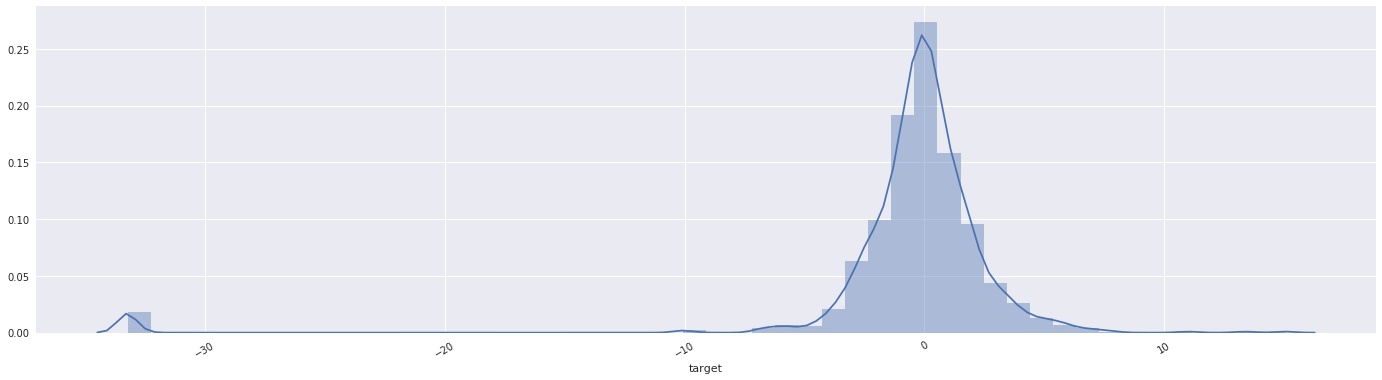

first_active_month: 2017-02-01 00:00:00 | hist_regist_term: 13
target max: 10.44978833 | min:-33.21928095


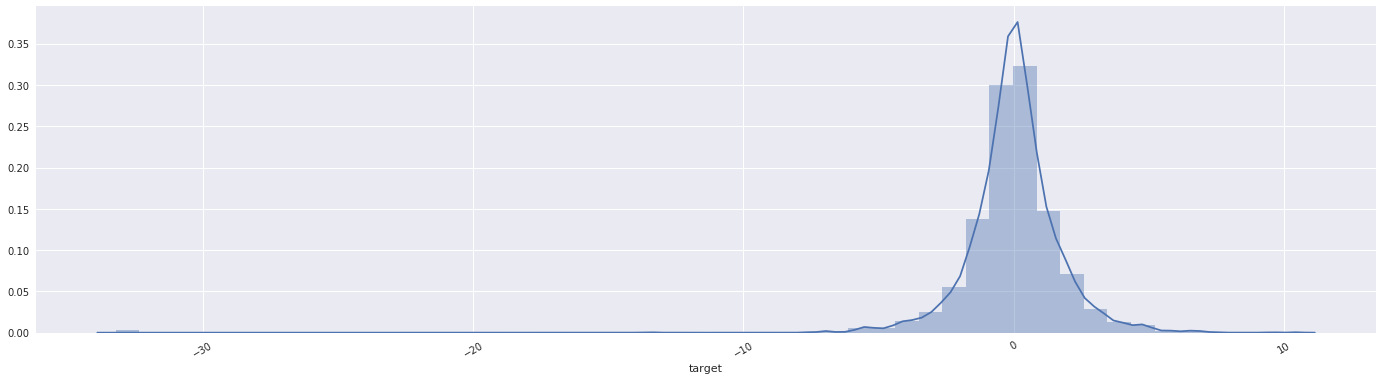

first_active_month: 2015-06-01 00:00:00 | hist_regist_term: 14
target max: 5.50956334 | min:-33.21928095


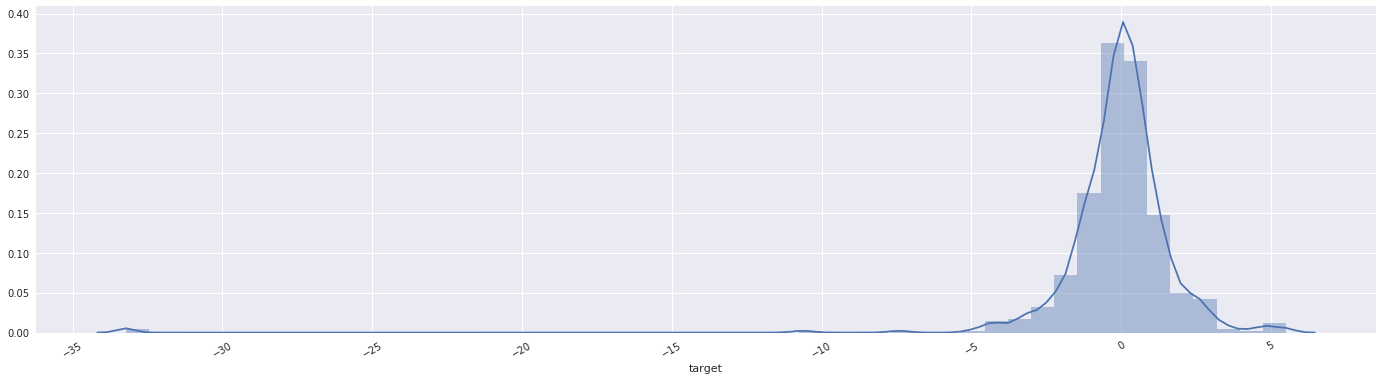

first_active_month: 2015-07-01 00:00:00 | hist_regist_term: 14
target max: 6.6632581 | min:-33.21928095


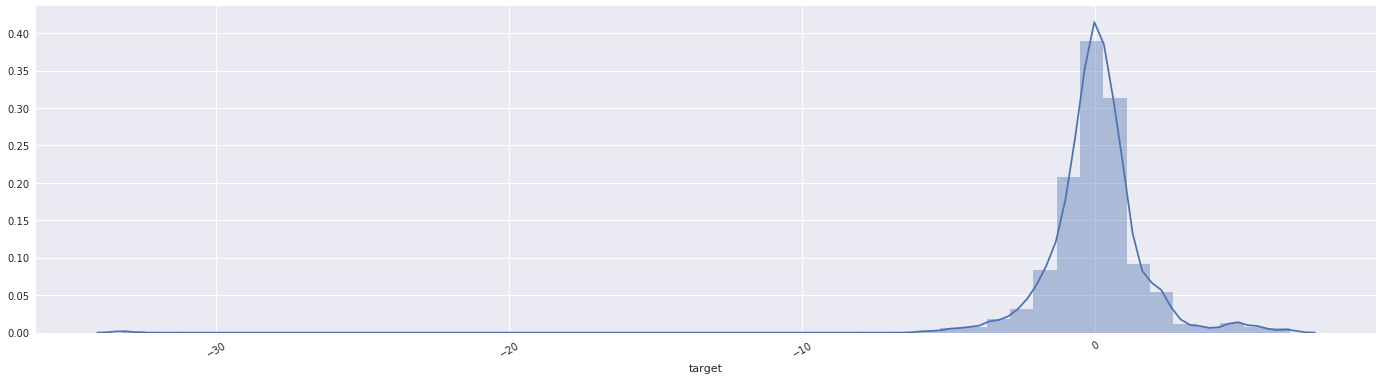

first_active_month: 2015-08-01 00:00:00 | hist_regist_term: 14
target max: 6.22119367 | min:-33.21928095


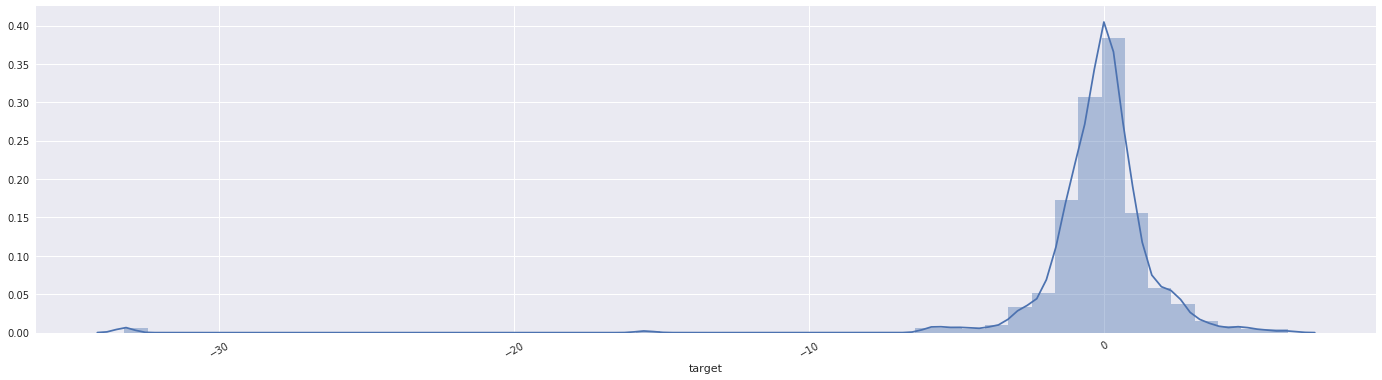

first_active_month: 2015-09-01 00:00:00 | hist_regist_term: 14
target max: 5.41260518 | min:-4.80368643


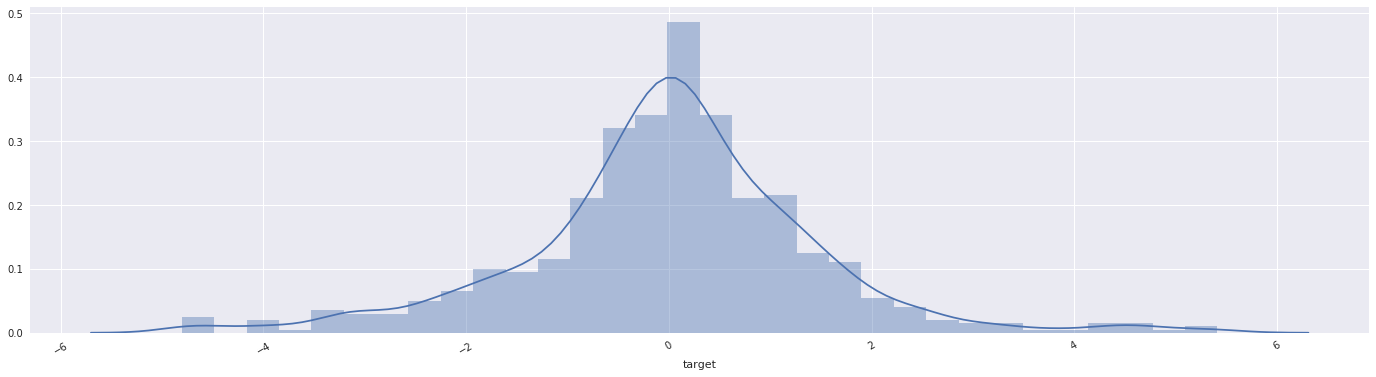

first_active_month: 2015-10-01 00:00:00 | hist_regist_term: 14
target max: 6.43577411 | min:-33.21928095


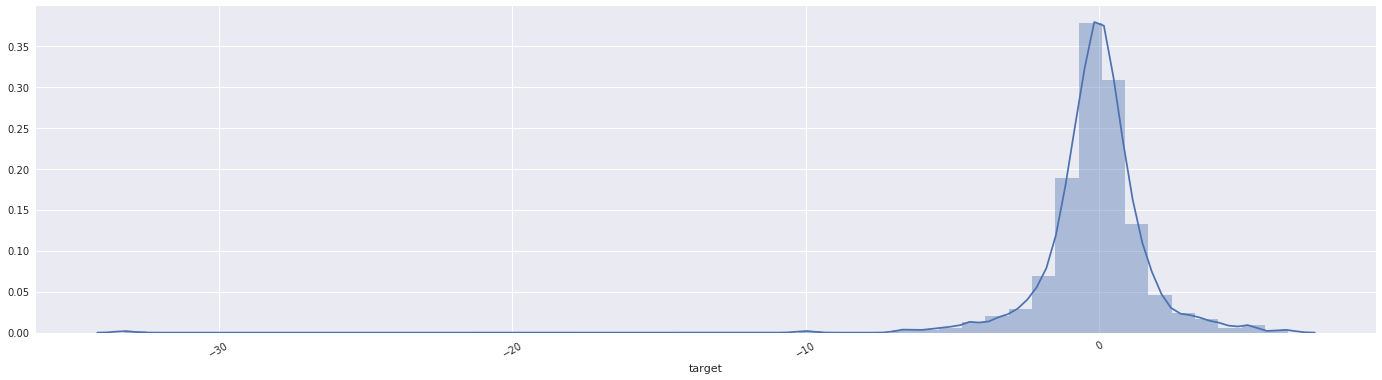

first_active_month: 2015-11-01 00:00:00 | hist_regist_term: 14
target max: 7.22391148 | min:-33.21928095


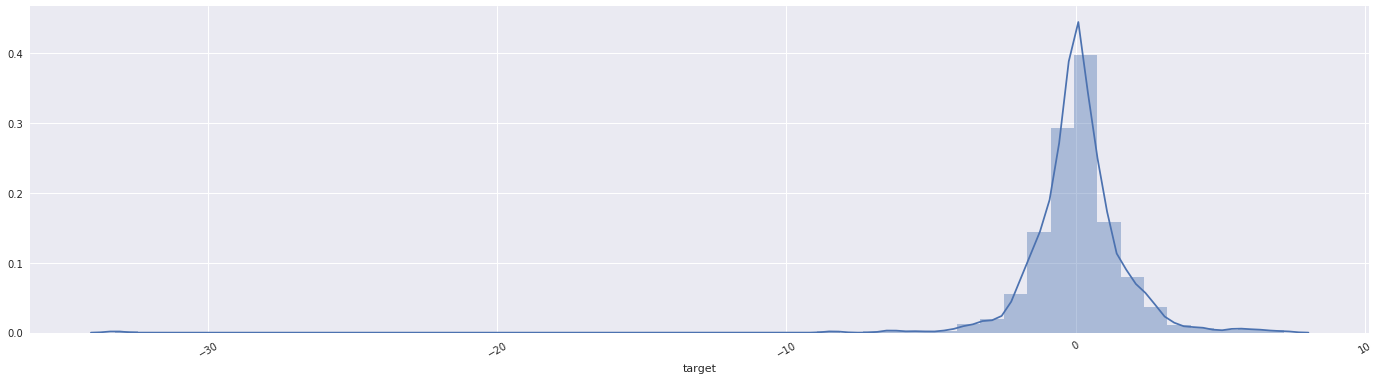

first_active_month: 2015-12-01 00:00:00 | hist_regist_term: 14
target max: 7.04502243 | min:-33.21928095


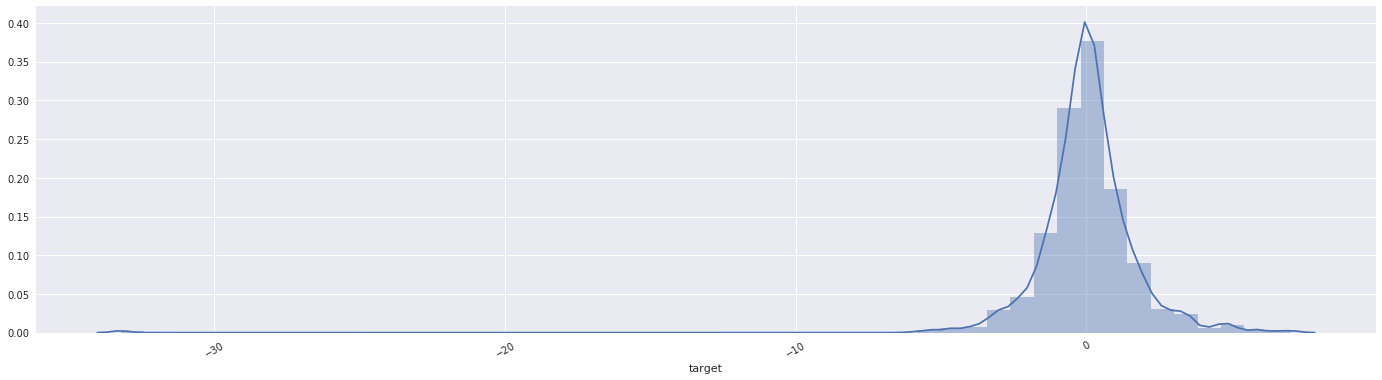

first_active_month: 2016-01-01 00:00:00 | hist_regist_term: 14
target max: 7.40955664 | min:-33.21928095


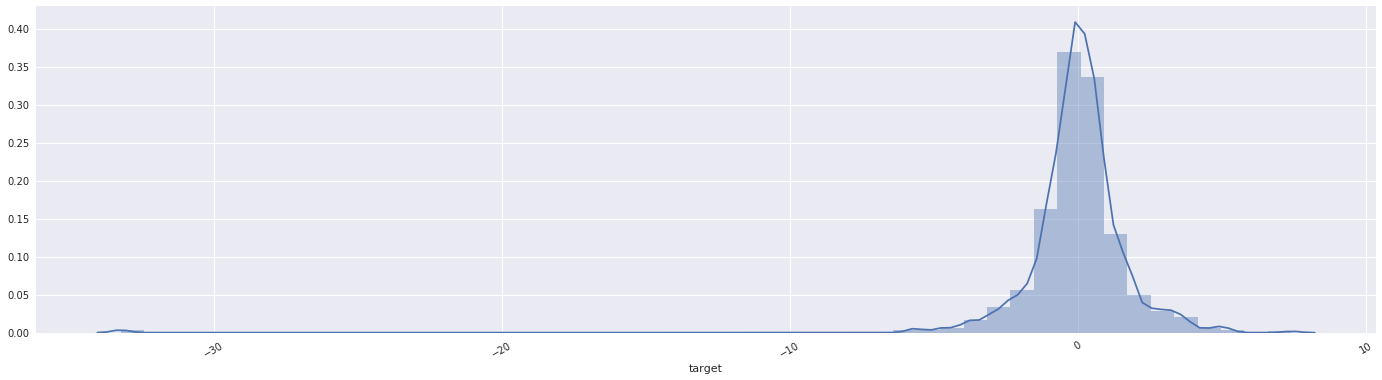

first_active_month: 2016-02-01 00:00:00 | hist_regist_term: 14
target max: 6.61605367 | min:-33.21928095


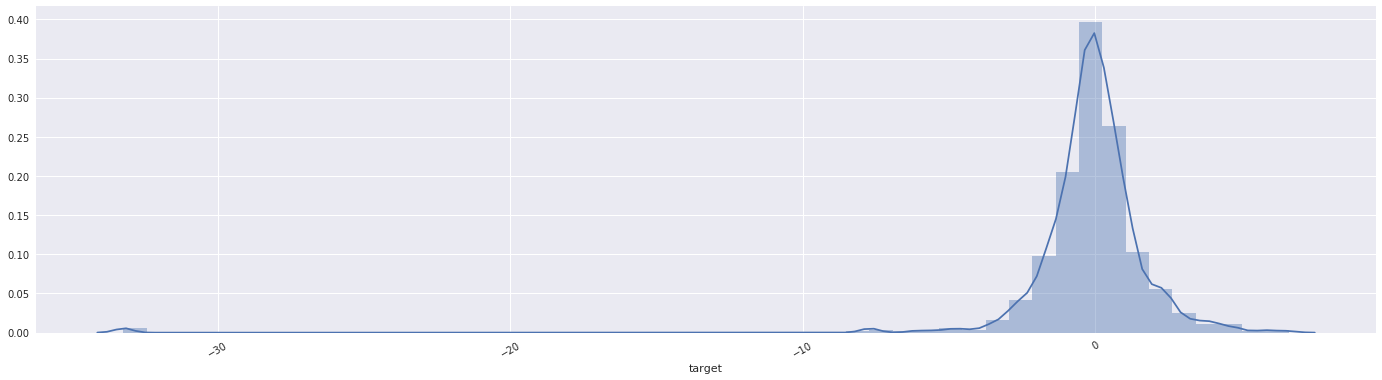

first_active_month: 2016-03-01 00:00:00 | hist_regist_term: 14
target max: 8.41390554 | min:-33.21928095


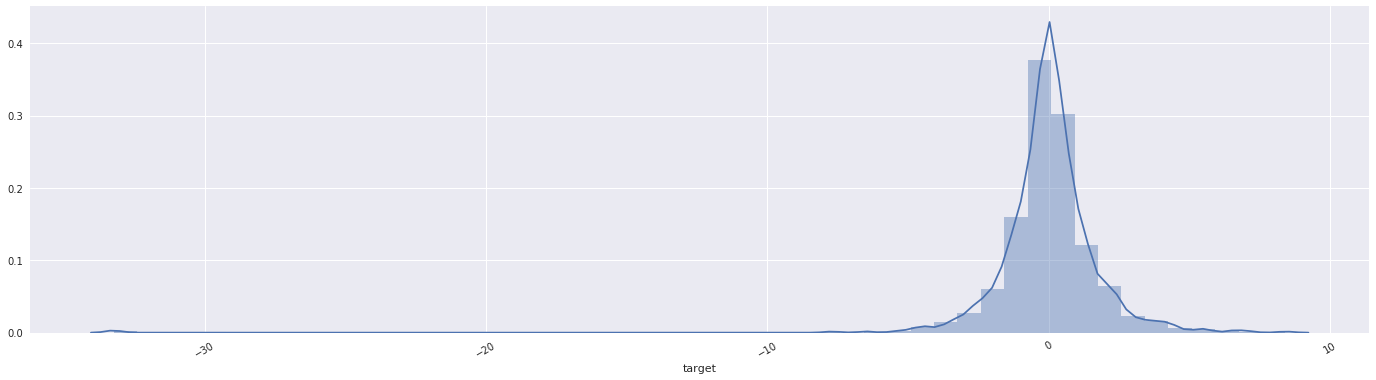

first_active_month: 2016-04-01 00:00:00 | hist_regist_term: 14
target max: 6.17664192 | min:-8.20880336


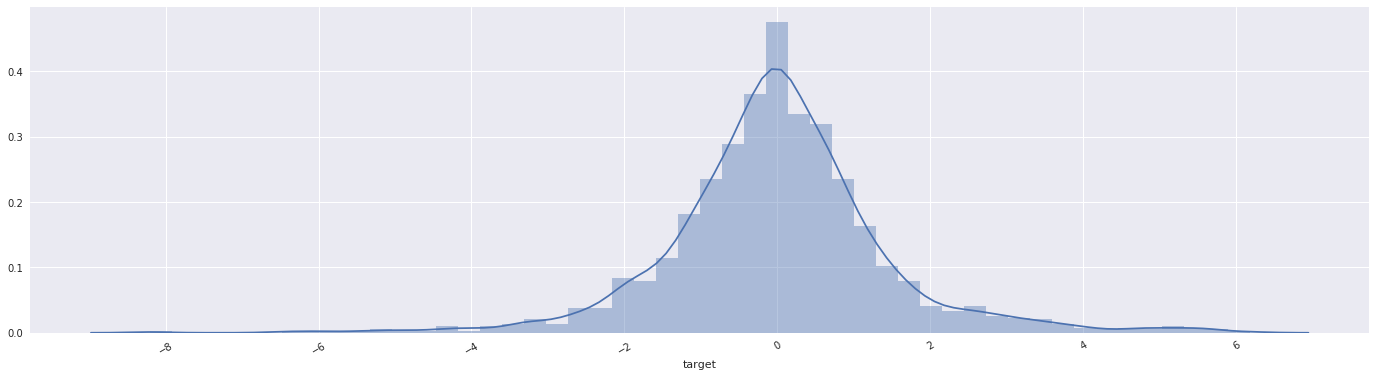

first_active_month: 2016-05-01 00:00:00 | hist_regist_term: 14
target max: 7.32396189 | min:-8.54217934


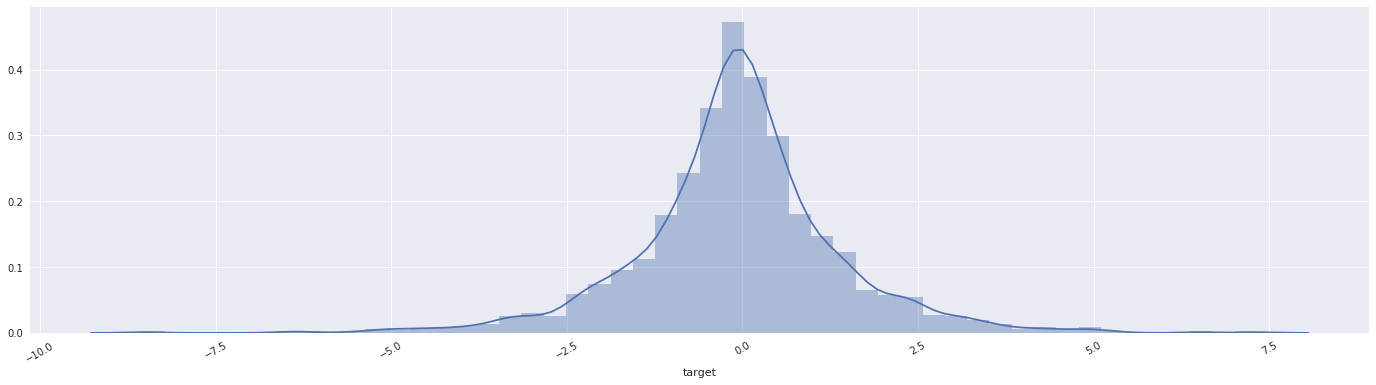

first_active_month: 2016-06-01 00:00:00 | hist_regist_term: 14
target max: 7.77962744 | min:-33.21928095


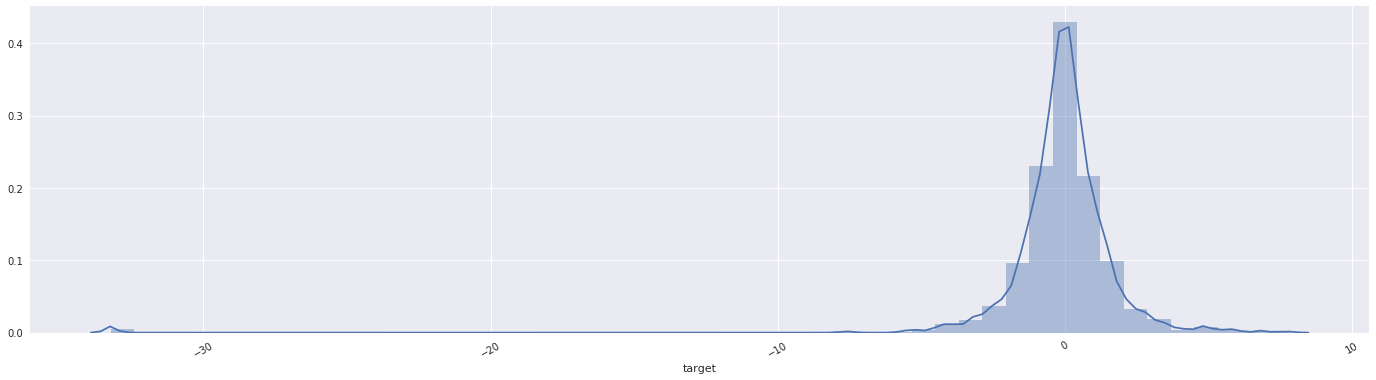

first_active_month: 2016-07-01 00:00:00 | hist_regist_term: 14
target max: 7.92563556 | min:-33.21928095


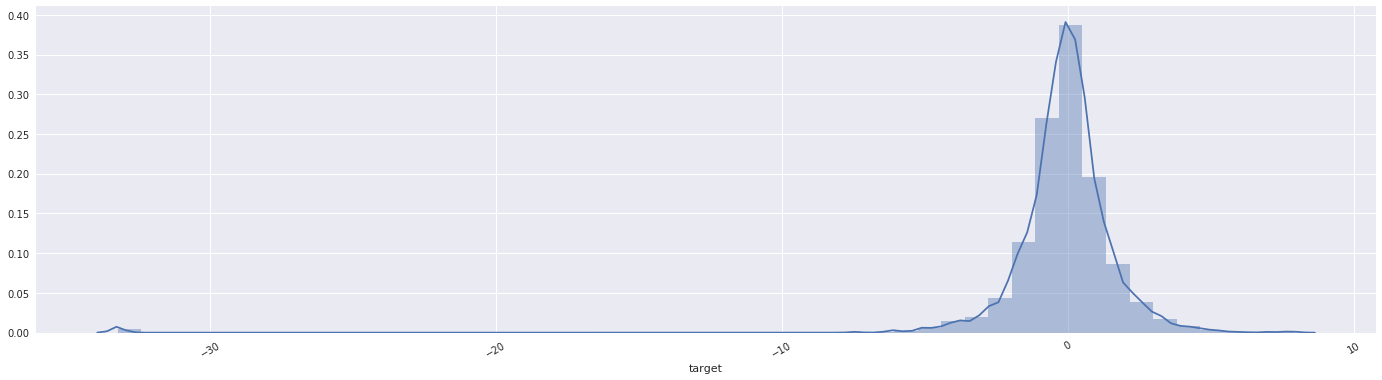

first_active_month: 2016-08-01 00:00:00 | hist_regist_term: 14
target max: 8.90840842 | min:-33.21928095


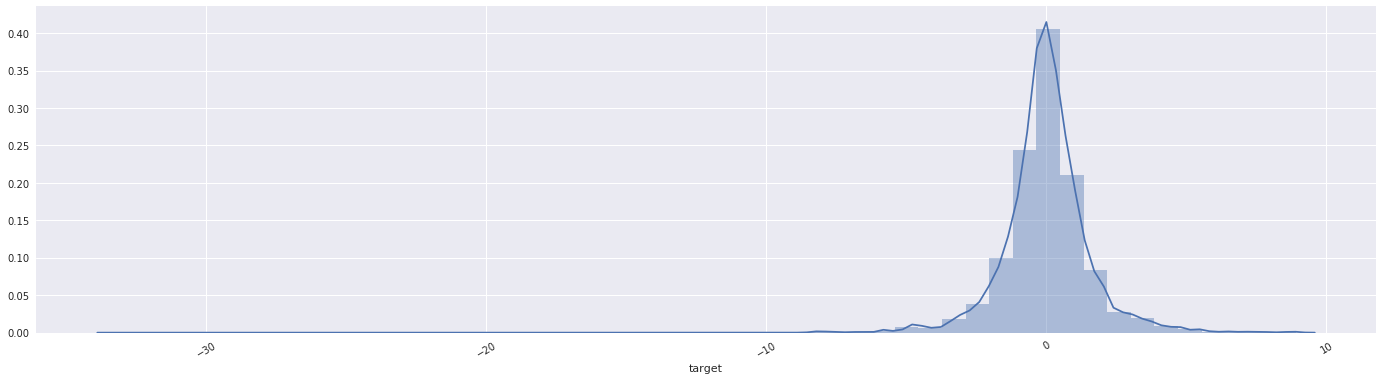

first_active_month: 2016-09-01 00:00:00 | hist_regist_term: 14
target max: 8.78162953 | min:-33.21928095


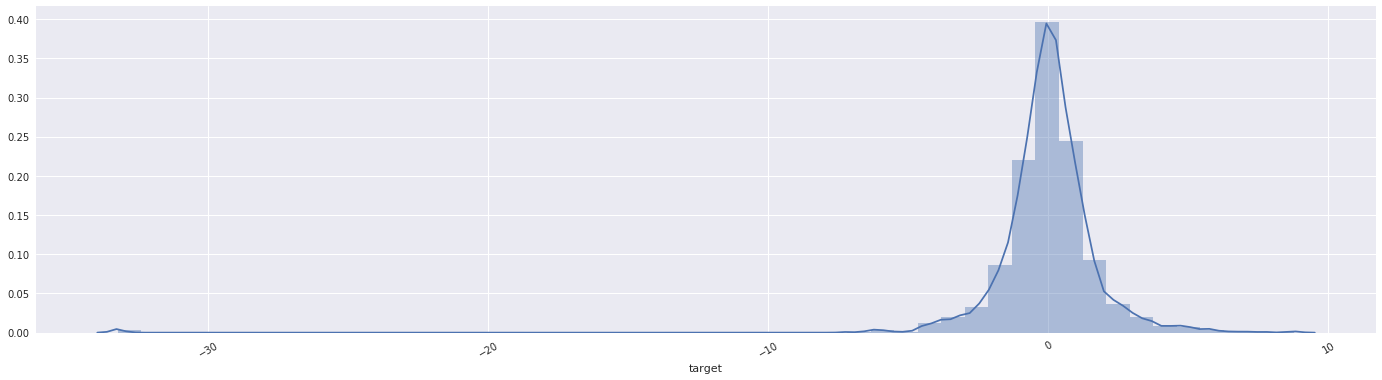

first_active_month: 2016-10-01 00:00:00 | hist_regist_term: 14
target max: 10.24119666 | min:-33.21928095


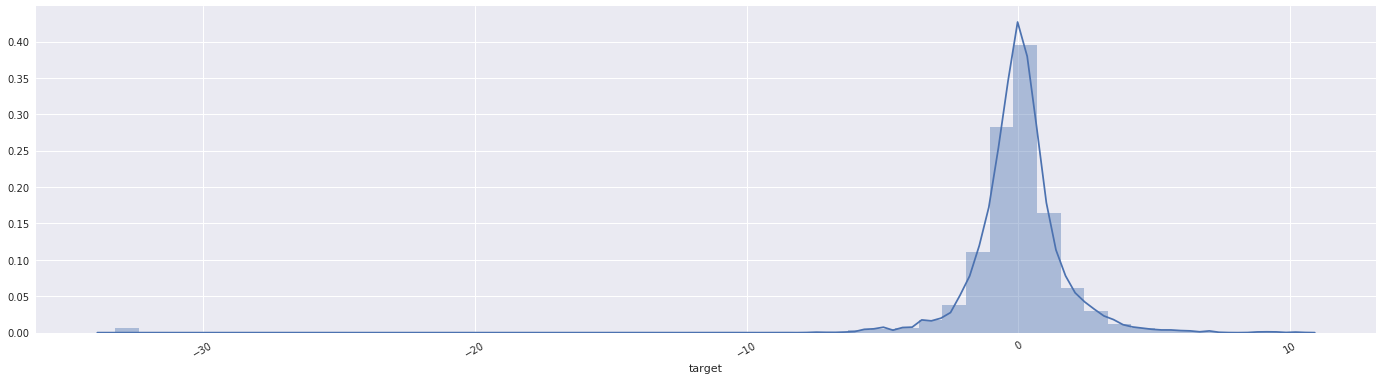

first_active_month: 2016-11-01 00:00:00 | hist_regist_term: 14
target max: 11.3337815 | min:-33.21928095


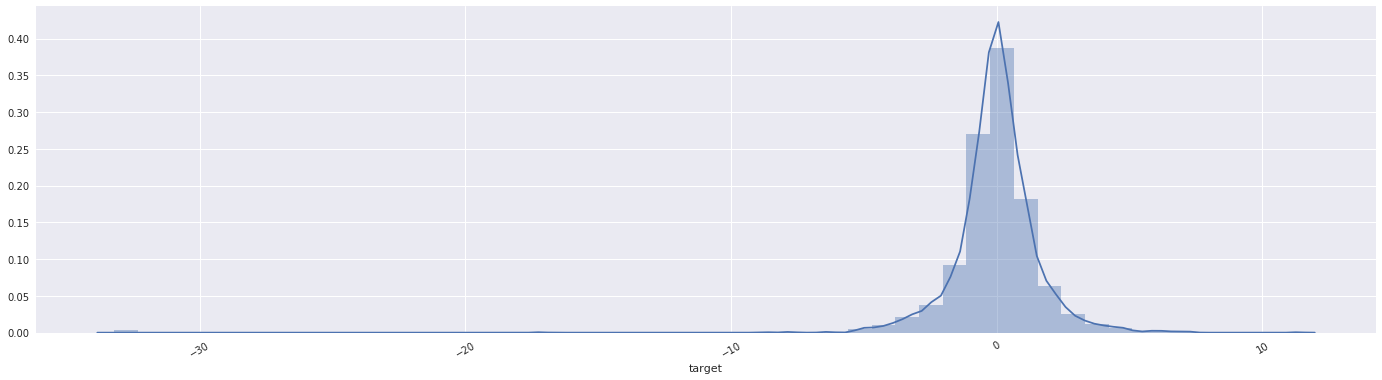

first_active_month: 2016-12-01 00:00:00 | hist_regist_term: 14
target max: 8.17921245 | min:-33.21928095


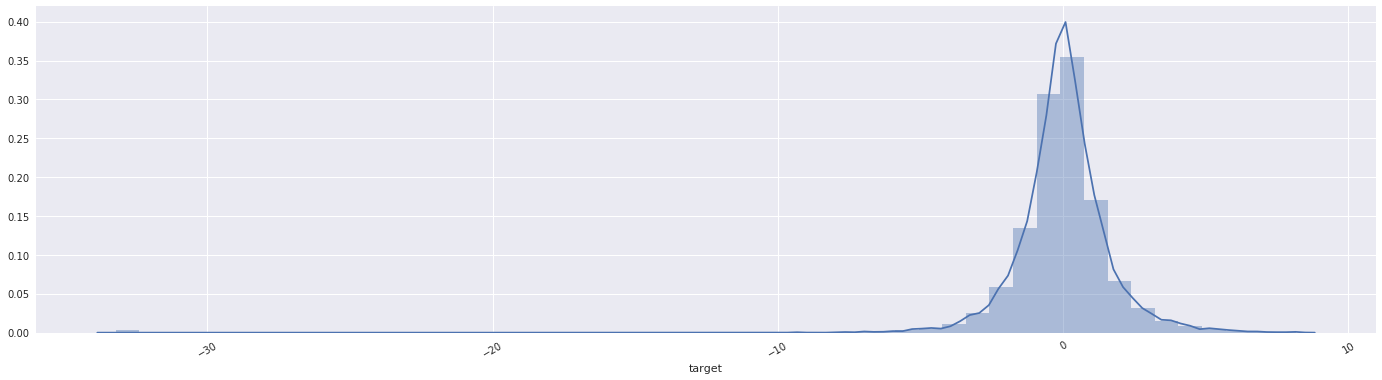

first_active_month: 2017-01-01 00:00:00 | hist_regist_term: 14
target max: 17.67571588 | min:-33.21928095


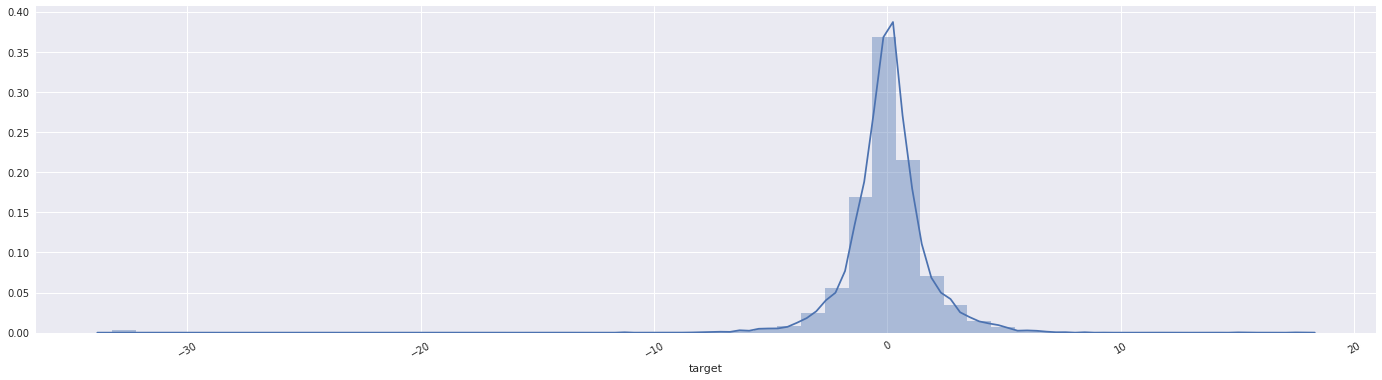

In [26]:
"""
-- My hypothesis --
I think that the hypothesis of raddar is correct, 
but I was grouped by the period from registration and last_month of each card_id, 
and among them I thought the royalty was relatively determined.
If target is calculated only by the ratio of amount, is this all group normal with this grouping? 
(it will come closer as the number of samples increases.)
I do not know the answer, but I am trying to model each group with this grouping.

"""

term_list = sorted(list(base['hist_regist_term'].value_counts().index))
fam_list = sorted(list(base['first_active_month'].value_counts().index))
train = base[~base[target].isnull()]

# less than 500record group doesn't viz
for term in term_list:
    for fam in fam_list:
        tmp = train[train['hist_personal_term']==term][train['first_active_month']==fam]
        if len(tmp)<500:
            continue
        
        print(f"first_active_month: {fam} | hist_regist_term: {term}")
        print(f"target max: {tmp[target].max()} | min:{tmp[target].min()}")
        plt.figure(figsize=(24, 6))
        sns.distplot(a=tmp['target'])
        plt.xticks(rotation=30)
        plt.show()